Apply the idea of Contrastive Loss

# Import libraries

In [1]:
import random
# random.seed(12)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import cv2

import math
import pickle

# from pytorch_metric_learning import losses, miners, distances, reducers, testers
# from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

# Representation function def

In [4]:
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import seaborn as sns

label_dict={0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

def visualize_embedding(features, labels, label_dict=None, save_path=None):
    if label_dict is None:
        str_labels = labels
    else:
        str_labels = [label_dict[k] for k in labels]

    tsne_features = TSNE(n_components=2).fit_transform(features)
    fig, ax = plt.subplots(figsize=(15,10))
    sns.scatterplot(ax=ax, x=tsne_features[:,0], y=tsne_features[:,1], 
                    hue=str_labels, style=str_labels, palette="deep")

    if save_path is not None:
        fig.savefig(save_path)

    return fig, tsne_features


def visualize_cm(cm, save_path=None, str_labels=None):
    
    fig, ax = plt.subplots(figsize=(15,10))
    xticklabels = str_labels if str_labels is not None else 'auto'
    yticklabels = str_labels if str_labels is not None else 'auto'
    sns.heatmap(cm, vmin=0, vmax=1, ax=ax, annot=True, xticklabels=xticklabels, yticklabels=yticklabels)

    if save_path is not None:
        fig.savefig(save_path)

    return fig

# FERDataset

In [5]:
class FERDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff= pd.read_csv(dff) if type(dff) is str else dff
        
        self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixels']
#         X = X.split()
        X = np.array(X, dtype=np.uint8)
        X = X.reshape(48,48)
        
        y = int(self.dff.iloc[index]['emotion'])

        if self.transforms:
            X = self.transforms(image=X)['image']

#             X = torch.cat((X,X,X),0)

        return X, y

In [6]:
batch_size= 128

# df = pd.read_csv('/tf/data/Quan/fer2013/data/csv_file/fer2013.csv')
df = pd.read_csv('../../../data/Quan/fer2013/data/csv_file/fer2013.csv')

df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']


train_transforms = A.Compose([
#     A.CLAHE(),
    A.Resize(48,48),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, p=0.5, border_mode=0, value=0),
#     A.RandomCrop(height=40, width=40),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2()
])


test_transforms = A.Compose([
#     A.CLAHE(),
    A.Resize(48,48),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2()
])

# train_set = FERDataset(df_train, train_transforms)
train_set = FERDataset(df_train, train_transforms) # no augmentation!
val_set = FERDataset(df_val, test_transforms)
test_set = FERDataset(df_test, test_transforms)


train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)

<ipython-input-5-cc86490abb55>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]


# SimCLR idea

In [35]:
class ContrastLoss(nn.Module):
    def __init__(self, in_dim, emb_dim=None, out_dim=None, tempt = 1.):
        super(ContrastLoss, self).__init__()
        
        self.in_dim = in_dim
        self.emb_dim = emb_dim if emb_dim is not None else self.in_dim
        self.out_dim = out_dim if out_dim is not None else self.in_dim
        
        self.tempt = tempt
        
        self.gap = nn.AdaptiveAvgPool2d(output_size=(1,1))
        
        self.encode_mlp1 = nn.Sequential(nn.Linear(in_dim, emb_dim),
                                        nn.ReLU(),
                                        nn.Linear(emb_dim, emb_dim))
        self.encode_mlp2 = nn.Sequential(nn.Linear(in_dim, emb_dim),
                                        nn.ReLU(),
                                        nn.Linear(emb_dim, emb_dim))
        
        self.decode_mlp1 = nn.Sequential(nn.Linear(emb_dim, emb_dim),
                                        nn.ReLU(),
                                        nn.Linear(emb_dim, out_dim))
        self.decode_mlp2 = nn.Sequential(nn.Linear(emb_dim, emb_dim),
                                        nn.ReLU(),
                                        nn.Linear(emb_dim, out_dim))
        
    def forward(self, x, labels, return_embs=True):
        b = x.size(0)
        
        xflat = self.gap(x)
        xflat = xflat.flatten(1)
        
        x_en1 = self.encode_mlp1(xflat)
        x_en2 = self.encode_mlp2(xflat)
        
        x_de1 = self.decode_mlp1(x_en1)
        x_de2 = self.decode_mlp2(x_en2)
        
        # normalize
        x_de1 = x_de1 / x_de1.norm(dim=1)[:,None]
        x_de2 = x_de2 / x_de2.norm(dim=1)[:,None]
        
        mask = self.filter_mask(labels).to(x.device)
        
        # opt1
#         att = x_de1.unsqueeze(1) * x_de2.unsqueeze(0)  # shape: b x b x d
        # opt2
        att = torch.mm(x_de1, x_de2.permute(1,0)) # shape: b x b
        att = att / (self.emb_dim ** (1/2))
        att = -nn.LogSoftmax(0)(att.flatten())
        
        if return_embs:
            return att, mask.flatten(), (x_en1, x_en2), (x_de1, x_de2)
        
        return att, mask.flatten()
        
    def filter_mask(self, labels):
        """
        mask zeroing them same
        """
        classes = torch.unique(labels)
        mask = torch.ones((len(labels), len(labels)))

        indices = [(labels == k).nonzero().flatten() for k in classes]
        lindices = [torch.combinations(k, r=2, with_replacement=True) for k in indices]
        rindices = [torch.combinations(k.flip(0), r=2, with_replacement=True) for k in indices]
        indices = [torch.cat([lindices[i], rindices[i]]) for i in range(len(lindices))]
        indices = [torch.unique(k, dim=0) for k in indices]

        for k in indices:
            mask[k[:,0], k[:,1]] = 0.

        spec_masks = []
        for k in indices:
            _temp = torch.zeros((len(labels), len(labels)))
            _temp[k[:,0], k[:,1]] = 1
            spec_masks.append(_temp)

        return mask

In [36]:
class sVGG_exp(nn.Module):
    def __init__(self, features, in_features_classifier, n_classes):
        super(sVGG_exp, self).__init__()
        self.features = features
        self.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.contrast_loss = ContrastLoss(512, 512, 512)

#         self.classifier = nn.Sequential(nn.Flatten(),
#                                         nn.Linear(in_features_classifier, in_features_classifier),
#                                         nn.ReLU(inplace=True),
#                                         nn.Dropout(0.5, inplace=False),
#                                         nn.Linear(in_features_classifier, in_features_classifier // 2),
#                                         nn.ReLU(inplace=True),
#                                         nn.Dropout(0.5, inplace=False),
#                                         nn.Linear(in_features_classifier // 2, n_classes))
        
    def forward(self, x, labels, return_att=True):
        x = self.features(x)
        att, mlabels, (en1, en2), (de1, de2) = self.contrast_loss(x, labels)

#         att = self.avgpool(x)
#         x = self.classifier(att)
        
        if return_att:
            return att, mlabels, (en1, en2), (de1, de2)
        return att, mlabels
        

In [41]:
from torchvision.models import vgg16_bn
sample_model = vgg16_bn(pretrained=True)
model = sVGG_exp(features=sample_model.features[:34], in_features_classifier=512, n_classes=7)

In [42]:
lr = 0.0005
epochs = 50
device = torch.device('cuda')

model = model.to(device)
# criterion = nn.CrossEntropyLoss()
sims_criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

best_acc = 0.0
hist = []

In [43]:
model_path = 'contrast_loss/contrastloss_demo.pt'
epochs = 50
# train
best_acc = 0.0
best_loss = 1e2
curloss = -1
hist = []

for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_simloss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

#             print('Unique labels: ', torch.unique(labels))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        att, mlabels, (en1, en2), (de1, de2) = model(inputs, labels)
        
        loss = sims_criterion(att, mlabels)
#         loss = criterion(outputs, labels) + sims_loss
#         acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
#         running_simloss += (sims_loss.item() * inputs.size((0)))
#         running_acc += acc.item()
        processed += len(inputs)

#         pbar.set_description(desc= f'Loss={loss.item()} Simloss={sims_loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i}')
    
    print('- Avg.loss: %.4f | Avg.sims_loss: %.4f |Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_simloss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
#     avgacc = running_acc / len(train_loader.dataset)
    
    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valsimloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        att, mlabels, (en1, en2), (de1, de2) = model(inputs, labels)

        loss = sims_criterion(att, mlabels)
#         loss = criterion(outputs, labels) + sims_loss
#         acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
#         running_valsimloss += (sims_loss.item() * inputs.size((0)))
#         running_valacc += acc.item()

    print('- Avg. test_loss: %.4f | Avg. test_sims_loss: %4f | Avg. test_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valsimloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))
    print('- Avg. test_loss: %.4f' % (running_valloss / len(val_loader.dataset)))    

    avgvalloss = running_valloss / len(val_loader.dataset)
#     avgvalacc = running_valacc / len(val_loader.dataset)

    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss])

    if best_loss > avgvalloss:
        best_loss = avgvalloss
        curloss = avgvalloss
        if model_path is not None:
            torch.save(model, model_path)
        print('* Update optimal model')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.3249531984329224 Batch_id=224: 100%|██████████| 225/225 [00:16<00:00, 13.77it/s]

- Avg.loss: 1.7462 | Avg.sims_loss: 0.0000 |Avg.acc: 0.0000


- Avg. test_loss: 1.7476 | Avg. test_sims_loss: 0.000000 | Avg. test_acc: 0.0000
- Avg. test_loss: 1.7476


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  2


Loss=1.356475830078125 Batch_id=224: 100%|██████████| 225/225 [00:16<00:00, 13.73it/s] 

- Avg.loss: 1.7443 | Avg.sims_loss: 0.0000 |Avg.acc: 0.0000


- Avg. test_loss: 1.7475 | Avg. test_sims_loss: 0.000000 | Avg. test_acc: 0.0000
- Avg. test_loss: 1.7475


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=1.524961233139038 Batch_id=224: 100%|██████████| 225/225 [00:16<00:00, 13.69it/s] 

- Avg.loss: 1.7436 | Avg.sims_loss: 0.0000 |Avg.acc: 0.0000


- Avg. test_loss: 1.7473 | Avg. test_sims_loss: 0.000000 | Avg. test_acc: 0.0000
- Avg. test_loss: 1.7473


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=1.5250272750854492 Batch_id=224: 100%|██████████| 225/225 [00:16<00:00, 13.70it/s]

- Avg.loss: 1.7436 | Avg.sims_loss: 0.0000 |Avg.acc: 0.0000


- Avg. test_loss: 1.7469 | Avg. test_sims_loss: 0.000000 | Avg. test_acc: 0.0000
- Avg. test_loss: 1.7469


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=1.3426718711853027 Batch_id=224: 100%|██████████| 225/225 [00:16<00:00, 13.77it/s]

- Avg.loss: 1.7461 | Avg.sims_loss: 0.0000 |Avg.acc: 0.0000



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 1.7471 | Avg. test_sims_loss: 0.000000 | Avg. test_acc: 0.0000
- Avg. test_loss: 1.7471
Epoch:  6


Loss=1.3347716331481934 Batch_id=224: 100%|██████████| 225/225 [00:16<00:00, 13.72it/s]

- Avg.loss: 1.7455 | Avg.sims_loss: 0.0000 |Avg.acc: 0.0000



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 1.7476 | Avg. test_sims_loss: 0.000000 | Avg. test_acc: 0.0000
- Avg. test_loss: 1.7476
Epoch:  7


Loss=1.4726333618164062 Batch_id=224: 100%|██████████| 225/225 [00:16<00:00, 13.73it/s]

- Avg.loss: 1.7446 | Avg.sims_loss: 0.0000 |Avg.acc: 0.0000



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 1.7473 | Avg. test_sims_loss: 0.000000 | Avg. test_acc: 0.0000
- Avg. test_loss: 1.7473
Epoch:  8


Loss=1.3329356908798218 Batch_id=224: 100%|██████████| 225/225 [00:16<00:00, 13.78it/s]

- Avg.loss: 1.7466 | Avg.sims_loss: 0.0000 |Avg.acc: 0.0000


- Avg. test_loss: 1.7464 | Avg. test_sims_loss: 0.000000 | Avg. test_acc: 0.0000
- Avg. test_loss: 1.7464


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=1.218360424041748 Batch_id=224: 100%|██████████| 225/225 [00:16<00:00, 13.80it/s] 

- Avg.loss: 1.7518 | Avg.sims_loss: 0.0000 |Avg.acc: 0.0000


- Avg. test_loss: 1.7462 | Avg. test_sims_loss: 0.000000 | Avg. test_acc: 0.0000
- Avg. test_loss: 1.7462


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Loss=1.2907099723815918 Batch_id=224: 100%|██████████| 225/225 [00:16<00:00, 13.75it/s]

- Avg.loss: 1.7464 | Avg.sims_loss: 0.0000 |Avg.acc: 0.0000



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 1.7465 | Avg. test_sims_loss: 0.000000 | Avg. test_acc: 0.0000
- Avg. test_loss: 1.7465
Epoch:  11


Loss=1.510953426361084 Batch_id=224: 100%|██████████| 225/225 [00:16<00:00, 13.82it/s] 

- Avg.loss: 1.7458 | Avg.sims_loss: 0.0000 |Avg.acc: 0.0000



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 1.7465 | Avg. test_sims_loss: 0.000000 | Avg. test_acc: 0.0000
- Avg. test_loss: 1.7465
Epoch:  12


Loss=1.4175676107406616 Batch_id=224: 100%|██████████| 225/225 [00:16<00:00, 13.84it/s]

- Avg.loss: 1.7415 | Avg.sims_loss: 0.0000 |Avg.acc: 0.0000



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 1.7464 | Avg. test_sims_loss: 0.000000 | Avg. test_acc: 0.0000
- Avg. test_loss: 1.7464
Epoch:  13


Loss=1.3864874839782715 Batch_id=224: 100%|██████████| 225/225 [00:16<00:00, 13.84it/s]

- Avg.loss: 1.7450 | Avg.sims_loss: 0.0000 |Avg.acc: 0.0000


- Avg. test_loss: 1.7461 | Avg. test_sims_loss: 0.000000 | Avg. test_acc: 0.0000
- Avg. test_loss: 1.7461


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  14


Loss=1.3550366163253784 Batch_id=224: 100%|██████████| 225/225 [00:16<00:00, 13.78it/s]

- Avg.loss: 1.7423 | Avg.sims_loss: 0.0000 |Avg.acc: 0.0000


- Avg. test_loss: 1.7458 | Avg. test_sims_loss: 0.000000 | Avg. test_acc: 0.0000
- Avg. test_loss: 1.7458


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  15


Loss=1.2496871948242188 Batch_id=224: 100%|██████████| 225/225 [00:16<00:00, 13.78it/s]

- Avg.loss: 1.7432 | Avg.sims_loss: 0.0000 |Avg.acc: 0.0000



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 1.7460 | Avg. test_sims_loss: 0.000000 | Avg. test_acc: 0.0000
- Avg. test_loss: 1.7460
Epoch:  16


Loss=1.4492955207824707 Batch_id=224: 100%|██████████| 225/225 [00:16<00:00, 13.81it/s]

- Avg.loss: 1.7467 | Avg.sims_loss: 0.0000 |Avg.acc: 0.0000



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 1.7460 | Avg. test_sims_loss: 0.000000 | Avg. test_acc: 0.0000
- Avg. test_loss: 1.7460
Epoch:  17


Loss=1.280073881149292 Batch_id=224: 100%|██████████| 225/225 [00:16<00:00, 13.84it/s] 

- Avg.loss: 1.7433 | Avg.sims_loss: 0.0000 |Avg.acc: 0.0000



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 1.7471 | Avg. test_sims_loss: 0.000000 | Avg. test_acc: 0.0000
- Avg. test_loss: 1.7471
Epoch:  18


Loss=1.2803092002868652 Batch_id=224: 100%|██████████| 225/225 [00:16<00:00, 13.81it/s]

- Avg.loss: 1.7447 | Avg.sims_loss: 0.0000 |Avg.acc: 0.0000



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 1.7465 | Avg. test_sims_loss: 0.000000 | Avg. test_acc: 0.0000
- Avg. test_loss: 1.7465
Epoch:  19


  0%|          | 0/225 [00:00<?, ?it/s]96%|█████████▌| 215/225 [00:15<00:00, 14.24it/s]

- Avg. test_loss: 1.7456 | Avg. test_sims_loss: 0.000000 | Avg. test_acc: 0.0000
- Avg. test_loss: 1.7456
Epoch:  27


Loss=1.4905836582183838 Batch_id=224: 100%|██████████| 225/225 [00:16<00:00, 13.84it/s]

- Avg.loss: 1.7486 | Avg.sims_loss: 0.0000 |Avg.acc: 0.0000


- Avg. test_loss: 1.7455 | Avg. test_sims_loss: 0.000000 | Avg. test_acc: 0.0000
- Avg. test_loss: 1.7455
Epoch    27: reducing learning rate of group 0 to 5.0000e-06.


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  28


Loss=1.493043065071106 Batch_id=224: 100%|██████████| 225/225 [00:16<00:00, 13.81it/s] 

- Avg.loss: 1.7451 | Avg.sims_loss: 0.0000 |Avg.acc: 0.0000



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 1.7456 | Avg. test_sims_loss: 0.000000 | Avg. test_acc: 0.0000
- Avg. test_loss: 1.7456
Epoch:  29


Loss=1.2701079845428467 Batch_id=224: 100%|██████████| 225/225 [00:16<00:00, 13.84it/s]

- Avg.loss: 1.7438 | Avg.sims_loss: 0.0000 |Avg.acc: 0.0000



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 1.7456 | Avg. test_sims_loss: 0.000000 | Avg. test_acc: 0.0000
- Avg. test_loss: 1.7456
Epoch:  30


Loss=1.4787540435791016 Batch_id=224: 100%|██████████| 225/225 [00:16<00:00, 13.87it/s]

- Avg.loss: 1.7439 | Avg.sims_loss: 0.0000 |Avg.acc: 0.0000



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 1.7456 | Avg. test_sims_loss: 0.000000 | Avg. test_acc: 0.0000
- Avg. test_loss: 1.7456
Epoch:  31


Loss=1.3761705160140991 Batch_id=224: 100%|██████████| 225/225 [00:16<00:00, 13.80it/s]

- Avg.loss: 1.7431 | Avg.sims_loss: 0.0000 |Avg.acc: 0.0000



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 1.7456 | Avg. test_sims_loss: 0.000000 | Avg. test_acc: 0.0000
- Avg. test_loss: 1.7456
Epoch:  32


Loss=1.3965295553207397 Batch_id=224: 100%|██████████| 225/225 [00:16<00:00, 13.80it/s]

- Avg.loss: 1.7475 | Avg.sims_loss: 0.0000 |Avg.acc: 0.0000



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 1.7456 | Avg. test_sims_loss: 0.000000 | Avg. test_acc: 0.0000
- Avg. test_loss: 1.7456
Epoch:  33


Loss=1.5866197347640991 Batch_id=224: 100%|██████████| 225/225 [00:16<00:00, 13.81it/s]

- Avg.loss: 1.7404 | Avg.sims_loss: 0.0000 |Avg.acc: 0.0000



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 1.7456 | Avg. test_sims_loss: 0.000000 | Avg. test_acc: 0.0000
- Avg. test_loss: 1.7456
Epoch    33: reducing learning rate of group 0 to 5.0000e-07.
Epoch:  34


Loss=1.9412400722503662 Batch_id=224: 100%|██████████| 225/225 [00:16<00:00, 13.80it/s]

- Avg.loss: 1.7511 | Avg.sims_loss: 0.0000 |Avg.acc: 0.0000



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 1.7456 | Avg. test_sims_loss: 0.000000 | Avg. test_acc: 0.0000
- Avg. test_loss: 1.7456
Epoch:  35


Loss=1.737030267715454 Batch_id=167:  75%|███████▍  | 168/225 [00:12<00:04, 14.20it/s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



([<matplotlib.lines.Line2D at 0x7f56f7a5fd90>,
 1.745538652092675)

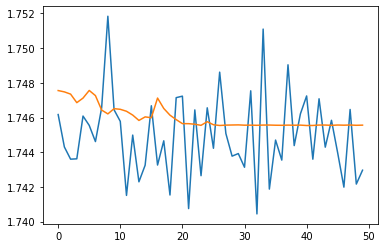

In [45]:
plt.plot(hist), best_loss

# Loss func

In [129]:
EPS = 1e-15
class ExpLoss(nn.Module):
    def __init__(self, depth, residual=True):
        super(ExpLoss, self).__init__()
        
        self.depth = depth
        self.residual = residual
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
        self.sims_logsoftmax = nn.Softmax(dim=1)
        
        self.proj1_in = nn.Sequential(nn.Linear(depth, depth),
                                 nn.BatchNorm1d(depth),
                                 nn.ReLU())
        self.proj2_in = nn.Sequential(nn.Linear(depth, depth),
                                 nn.BatchNorm1d(depth),
                                 nn.ReLU())
        
        self.proj1_out = nn.Sequential(nn.Linear(depth, depth),
                                 nn.BatchNorm1d(depth),
                                 nn.ReLU())
        self.proj2_out = nn.Sequential(nn.Linear(depth, depth),
                                 nn.BatchNorm1d(depth),
                                 nn.ReLU())
        
        self.out_fc = nn.Sequential(nn.Linear(depth, depth),
                                    nn.BatchNorm1d(depth),
                                    nn.ReLU())
        
    def forward(self, x, labels):
        batch_size = x.size(0)
        
        x = self.avgpool(x)
        x = self.flatten(x)
        
        if self.residual:
            x_res = x
        
        x = self.dropout(x)
        h1 = self.proj1_in(x)
        h2 = self.proj2_in(x)
        
        x1 = self.proj1_out(h1)
        x2 = self.proj2_out(h2)
        
        # normalize x1, x2
        x1 = x1 / x1.norm(dim=1)[:,None]
        x2 = x2 / x2.norm(dim=1)[:,None]
        
        # normalize z1, z2
        h1 = h1 / h1.norm(dim=1)[:,None]
        h2 = h2 / h2.norm(dim=1)[:,None]
        
        att = torch.mm(h1, h2.permute(1,0))
#         att_mask = torch.where(sims >= 0, 1, 0)
#         att = att * (att_mask.to(att_mask.device))

        x = torch.mm(att, x)
        x = self.out_fc(x)
    
        if self.residual:
            x = x + x_res
        
        # cal sims (batchsize, depth)
        sims = torch.mm(x1, x2.permute(1,0))
        sims_act = self.sims_logsoftmax(sims)
        pos_sims_act = -torch.log(sims_act)
        neg_sims_act = -torch.log(1-sims_act)
        
        mask_labels = self.filter_mask(labels)
        mask_labels = 1 - mask_labels # same labels as 1, different labels as 0
        mask_labels = mask_labels.to(labels.device)
        
        sims_loss = (pos_sims_act * mask_labels).sum(1).mean()
        neg_sims_loss = (neg_sims_act * (1-mask_labels)).sum(1).mean()
        
        return x, sims, mask_labels, sims_loss+neg_sims_loss # sims.sigmoid() and mask_labels are used to cal BCELoss

    def filter_mask(self, labels):
        """
        mask zeroing them same
        """
        classes = torch.unique(labels)
        mask = torch.ones((len(labels), len(labels)))

        indices = [(labels == k).nonzero().flatten() for k in classes]
        lindices = [torch.combinations(k, r=2, with_replacement=True) for k in indices]
        rindices = [torch.combinations(k.flip(0), r=2, with_replacement=True) for k in indices]
        indices = [torch.cat([lindices[i], rindices[i]]) for i in range(len(lindices))]
        indices = [torch.unique(k, dim=0) for k in indices]

        for k in indices:
            mask[k[:,0], k[:,1]] = 0.

        spec_masks = []
        for k in indices:
            _temp = torch.zeros((len(labels), len(labels)))
            _temp[k[:,0], k[:,1]] = 1
            spec_masks.append(_temp)

        return mask

In [130]:
def filter_mask(labels):
        """
        mask zeroing them same
        """
        classes = torch.unique(labels)
        mask = torch.ones((len(labels), len(labels)))

        indices = [(labels == k).nonzero().flatten() for k in classes]
        lindices = [torch.combinations(k, r=2, with_replacement=True) for k in indices]
        rindices = [torch.combinations(k.flip(0), r=2, with_replacement=True) for k in indices]
        indices = [torch.cat([lindices[i], rindices[i]]) for i in range(len(lindices))]
        indices = [torch.unique(k, dim=0) for k in indices]

        for k in indices:
            mask[k[:,0], k[:,1]] = 0.

        spec_masks = []
        for k in indices:
            _temp = torch.zeros((len(labels), len(labels)))
            _temp[k[:,0], k[:,1]] = 1
            spec_masks.append(_temp)

        return mask

In [136]:
class sVGG_exp(nn.Module):
    def __init__(self, features, in_features_classifier, n_classes):
        super(sVGG_exp, self).__init__()
        self.features = features
        self.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.exploss = ExpLoss(512)
#         self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(in_features_classifier, in_features_classifier),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier, in_features_classifier // 2),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier // 2, n_classes))
        
    def forward(self, x, labels, return_att=True):
        x = self.features(x)
        att, sims, sims_labels, sims_loss = self.exploss(x, labels)

#         att = self.avgpool(x)
        x = self.classifier(att)
        
        if return_att:
            return x, sims, sims_labels, att, sims_loss
        return x, sims, sims_labels, sims_loss
        

In [132]:
from torchvision.models import vgg16_bn
sample_model = vgg16_bn(pretrained=True)
model = sVGG_exp(features=sample_model.features[:34], in_features_classifier=512, n_classes=7)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/jovyan/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [133]:
lr = 0.0005
epochs = 50
device = torch.device('cuda')

model = model.to(device)
criterion = nn.CrossEntropyLoss()
sims_criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

best_acc = 0.0
hist = []

In [ ]:
model_path = None
epochs = 50
# train
best_acc = 0.0
curloss = -1
hist = []

for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_simloss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

#             print('Unique labels: ', torch.unique(labels))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sims, sims_labels, features, sims_loss = model(inputs, labels)
        
#         sims_loss = sims_criterion(sims, sims_labels)
        loss = criterion(outputs, labels) + sims_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_simloss += (sims_loss.item() * inputs.size((0)))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Simloss={sims_loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')
    
    print('- Avg.loss: %.4f | Avg.sims_loss: %.4f |Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_simloss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)
    
    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valsimloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sims, sims_labels, features, sims_loss = model(inputs, labels)

#         sims_loss = sims_criterion(sims, sims_labels)
        loss = criterion(outputs, labels) + sims_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valsimloss += (sims_loss.item() * inputs.size((0)))
        running_valacc += acc.item()

    print('- Avg. test_loss: %.4f | Avg. test_sims_loss: %4f | Avg. test_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valsimloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)

    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])

    if best_acc < avgvalacc:
        best_acc = avgvalacc
        curloss = avgvalloss
        if model_path is not None:
            torch.save(model, model_path)
        print('* Update optimal model')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=28.783926010131836 Simloss=27.00162696838379 Batch_id=448 Accuracy=0.35135135135135137: 100%|██████████| 449/449 [00:19<00:00, 23.07it/s]

- Avg.loss: 51.3531 | Avg.sims_loss: 49.4890 |Avg.acc: 0.2278



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 51.3411 | Avg. test_sims_loss: 49.510805 | Avg. test_acc: 0.2494
* Update optimal model
Epoch:  2


Loss=23.486530303955078 Simloss=21.63784408569336 Batch_id=448 Accuracy=0.16216216216216217: 100%|██████████| 449/449 [00:19<00:00, 22.98it/s]

- Avg.loss: 51.0102 | Avg.sims_loss: 49.2117 |Avg.acc: 0.2577



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 50.8938 | Avg. test_sims_loss: 49.166640 | Avg. test_acc: 0.3104
* Update optimal model
Epoch:  3


Loss=26.754655838012695 Simloss=25.216447830200195 Batch_id=448 Accuracy=0.40540540540540543: 100%|██████████| 449/449 [00:19<00:00, 23.00it/s]

- Avg.loss: 50.2951 | Avg.sims_loss: 48.5644 |Avg.acc: 0.2855



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 50.4762 | Avg. test_sims_loss: 48.774988 | Avg. test_acc: 0.3260
* Update optimal model
Epoch:  4


Loss=26.963815689086914 Simloss=25.398693084716797 Batch_id=448 Accuracy=0.4594594594594595: 100%|██████████| 449/449 [00:19<00:00, 23.06it/s]

- Avg.loss: 49.6441 | Avg.sims_loss: 48.0358 |Avg.acc: 0.3586



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 49.2871 | Avg. test_sims_loss: 47.762143 | Avg. test_acc: 0.3931
* Update optimal model
Epoch:  5


Loss=24.236574172973633 Simloss=22.665531158447266 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:19<00:00, 22.98it/s]

- Avg.loss: 48.9797 | Avg.sims_loss: 47.4587 |Avg.acc: 0.3988



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 48.8609 | Avg. test_sims_loss: 47.322916 | Avg. test_acc: 0.3736
Epoch:  6


Loss=35.25521469116211 Simloss=33.67858123779297 Batch_id=448 Accuracy=0.40540540540540543: 100%|██████████| 449/449 [00:19<00:00, 22.94it/s]

- Avg.loss: 48.7793 | Avg.sims_loss: 47.3116 |Avg.acc: 0.4168



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 48.6292 | Avg. test_sims_loss: 47.109823 | Avg. test_acc: 0.4394
* Update optimal model
Epoch:  7


Loss=24.291038513183594 Simloss=22.691390991210938 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:19<00:00, 22.98it/s]

- Avg.loss: 48.5616 | Avg.sims_loss: 47.1286 |Avg.acc: 0.4283



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 48.7115 | Avg. test_sims_loss: 47.232638 | Avg. test_acc: 0.4439
* Update optimal model
Epoch:  8


Loss=24.468830108642578 Simloss=23.098283767700195 Batch_id=448 Accuracy=0.4594594594594595: 100%|██████████| 449/449 [00:19<00:00, 23.04it/s]

- Avg.loss: 48.3804 | Avg.sims_loss: 46.9762 |Avg.acc: 0.4359



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 48.4665 | Avg. test_sims_loss: 46.987683 | Avg. test_acc: 0.4430
Epoch:  9


Loss=23.961219787597656 Simloss=22.43761444091797 Batch_id=448 Accuracy=0.3783783783783784: 100%|██████████| 449/449 [00:19<00:00, 22.94it/s]

- Avg.loss: 48.4565 | Avg.sims_loss: 47.0614 |Avg.acc: 0.4409



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 48.6469 | Avg. test_sims_loss: 47.083802 | Avg. test_acc: 0.4179
Epoch:  10


Loss=23.3707332611084 Simloss=21.80211067199707 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [00:19<00:00, 22.98it/s]

- Avg.loss: 48.3464 | Avg.sims_loss: 46.9689 |Avg.acc: 0.4452



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 48.4123 | Avg. test_sims_loss: 46.949272 | Avg. test_acc: 0.4230
Epoch:  11


Loss=24.657398223876953 Simloss=23.59120750427246 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:19<00:00, 23.00it/s]

- Avg.loss: 48.2212 | Avg.sims_loss: 46.8615 |Avg.acc: 0.4481



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 48.2765 | Avg. test_sims_loss: 46.859800 | Avg. test_acc: 0.4597
* Update optimal model
Epoch:  12


Loss=25.92572593688965 Simloss=24.604698181152344 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:19<00:00, 22.99it/s]

- Avg.loss: 47.9354 | Avg.sims_loss: 46.5916 |Avg.acc: 0.4557



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 48.3879 | Avg. test_sims_loss: 46.914064 | Avg. test_acc: 0.4296
Epoch:  13


Loss=29.274019241333008 Simloss=28.020795822143555 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:19<00:00, 22.98it/s]

- Avg.loss: 47.9268 | Avg.sims_loss: 46.5854 |Avg.acc: 0.4596



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 48.2940 | Avg. test_sims_loss: 46.893792 | Avg. test_acc: 0.4402
Epoch:  14


Loss=22.391664505004883 Simloss=20.80774688720703 Batch_id=448 Accuracy=0.40540540540540543: 100%|██████████| 449/449 [00:19<00:00, 22.95it/s]

- Avg.loss: 47.9163 | Avg.sims_loss: 46.5898 |Avg.acc: 0.4641



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 48.1436 | Avg. test_sims_loss: 46.760272 | Avg. test_acc: 0.4664
* Update optimal model
Epoch:  15


Loss=26.310529708862305 Simloss=24.965253829956055 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:19<00:00, 22.95it/s]

- Avg.loss: 47.8019 | Avg.sims_loss: 46.4904 |Avg.acc: 0.4723



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 48.0796 | Avg. test_sims_loss: 46.728953 | Avg. test_acc: 0.4567
Epoch:  16


Loss=24.021425247192383 Simloss=22.964643478393555 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:19<00:00, 22.91it/s]

- Avg.loss: 47.6461 | Avg.sims_loss: 46.3512 |Avg.acc: 0.4826



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 48.3178 | Avg. test_sims_loss: 46.842334 | Avg. test_acc: 0.4469
Epoch:  17


Loss=27.097375869750977 Simloss=25.767065048217773 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:19<00:00, 22.96it/s]

- Avg.loss: 47.4620 | Avg.sims_loss: 46.1829 |Avg.acc: 0.4959



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 47.9895 | Avg. test_sims_loss: 46.675371 | Avg. test_acc: 0.5029
* Update optimal model
Epoch:  18


Loss=46.71342849731445 Simloss=45.72481155395508 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:19<00:00, 22.96it/s]

- Avg.loss: 47.5143 | Avg.sims_loss: 46.2510 |Avg.acc: 0.5123



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 47.8796 | Avg. test_sims_loss: 46.539936 | Avg. test_acc: 0.5043
* Update optimal model
Epoch:  19


Loss=25.4078426361084 Simloss=23.99586296081543 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:19<00:00, 22.95it/s]

- Avg.loss: 47.3483 | Avg.sims_loss: 46.1127 |Avg.acc: 0.5277



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 48.0966 | Avg. test_sims_loss: 46.664960 | Avg. test_acc: 0.4770
Epoch:  20


Loss=28.604665756225586 Simloss=27.305604934692383 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:19<00:00, 22.92it/s]

- Avg.loss: 47.4882 | Avg.sims_loss: 46.2600 |Avg.acc: 0.5278



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 47.8144 | Avg. test_sims_loss: 46.509392 | Avg. test_acc: 0.5202
* Update optimal model
Epoch:  21


Loss=25.05862045288086 Simloss=23.946043014526367 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:19<00:00, 22.88it/s]

- Avg.loss: 47.5321 | Avg.sims_loss: 46.3279 |Avg.acc: 0.5452



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 47.8587 | Avg. test_sims_loss: 46.552907 | Avg. test_acc: 0.5082
Epoch:  22


Loss=25.467994689941406 Simloss=24.204708099365234 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [00:19<00:00, 22.83it/s]

- Avg.loss: 47.3731 | Avg.sims_loss: 46.1683 |Avg.acc: 0.5463



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 48.0220 | Avg. test_sims_loss: 46.636137 | Avg. test_acc: 0.4854
Epoch:  23


Loss=28.28254508972168 Simloss=27.245134353637695 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:19<00:00, 22.85it/s]

- Avg.loss: 47.1981 | Avg.sims_loss: 46.0055 |Avg.acc: 0.5551



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 48.6611 | Avg. test_sims_loss: 46.757555 | Avg. test_acc: 0.3987
Epoch:  24


Loss=23.053009033203125 Simloss=21.744062423706055 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [00:19<00:00, 22.90it/s]

- Avg.loss: 47.0833 | Avg.sims_loss: 45.9090 |Avg.acc: 0.5628



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 47.8192 | Avg. test_sims_loss: 46.484143 | Avg. test_acc: 0.5319
* Update optimal model
Epoch:  25


Loss=22.1481990814209 Simloss=20.710887908935547 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [00:19<00:00, 22.83it/s]

- Avg.loss: 47.1946 | Avg.sims_loss: 46.0310 |Avg.acc: 0.5688



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 47.6568 | Avg. test_sims_loss: 46.399314 | Avg. test_acc: 0.5442
* Update optimal model
Epoch:  26


Loss=33.00048828125 Simloss=31.6395263671875 Batch_id=448 Accuracy=0.4594594594594595: 100%|██████████| 449/449 [00:19<00:00, 22.86it/s]

- Avg.loss: 46.9656 | Avg.sims_loss: 45.8243 |Avg.acc: 0.5789



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 47.7257 | Avg. test_sims_loss: 46.467370 | Avg. test_acc: 0.5439
Epoch:  27


Loss=48.6466064453125 Simloss=47.476524353027344 Batch_id=314 Accuracy=0.5:  70%|██████▉   | 313/449 [00:13<00:05, 23.27it/s]       

In [71]:
for epoch in range(epochs, 100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_simloss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

#             print('Unique labels: ', torch.unique(labels))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sims, sims_labels, features, sims_loss = model(inputs, labels)
        
#         sims_loss = sims_criterion(sims, sims_labels)
        loss = criterion(outputs, labels) + sims_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_simloss += (sims_loss.item() * inputs.size((0)))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Simloss={sims_loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')
    
    print('- Avg.loss: %.4f | Avg.sims_loss: %.4f |Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_simloss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)
    
    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valsimloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sims, sims_labels, features, sims_loss = model(inputs, labels)

#         sims_loss = sims_criterion(sims, sims_labels)
        loss = criterion(outputs, labels) + sims_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valsimloss += (sims_loss.item() * inputs.size((0)))
        running_valacc += acc.item()

    print('- Avg. test_loss: %.4f | Avg. test_sims_loss: %4f | Avg. test_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valsimloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)

    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])

    if best_acc < avgvalacc:
        best_acc = avgvalacc
        curloss = avgvalloss
        if model_path is not None:
            torch.save(model, model_path)
        print('* Update optimal model')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  51


Loss=22.953899383544922 Simloss=22.242769241333008 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:19<00:00, 23.11it/s]

- Avg.loss: 45.2120 | Avg.sims_loss: 44.4314 |Avg.acc: 0.7469



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 47.3122 | Avg. test_sims_loss: 46.155971 | Avg. test_acc: 0.6258
Epoch:  52


Loss=21.26699447631836 Simloss=20.124191284179688 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:19<00:00, 23.12it/s]

- Avg.loss: 45.3441 | Avg.sims_loss: 44.5678 |Avg.acc: 0.7504



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 47.2935 | Avg. test_sims_loss: 46.149528 | Avg. test_acc: 0.6294
Epoch:  53


Loss=31.166831970214844 Simloss=30.389692306518555 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:19<00:00, 23.01it/s]

- Avg.loss: 45.1518 | Avg.sims_loss: 44.3829 |Avg.acc: 0.7528



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 47.2675 | Avg. test_sims_loss: 46.123813 | Avg. test_acc: 0.6303
Epoch    53: reducing learning rate of group 0 to 5.0000e-06.
* Update optimal model
Epoch:  54


Loss=24.449203491210938 Simloss=23.40249252319336 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:19<00:00, 23.09it/s]

- Avg.loss: 45.1809 | Avg.sims_loss: 44.4157 |Avg.acc: 0.7535



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 47.2752 | Avg. test_sims_loss: 46.125725 | Avg. test_acc: 0.6261
Epoch:  55


Loss=21.36284828186035 Simloss=20.62495231628418 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:19<00:00, 23.05it/s]

- Avg.loss: 45.0749 | Avg.sims_loss: 44.3161 |Avg.acc: 0.7567



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 47.2618 | Avg. test_sims_loss: 46.118583 | Avg. test_acc: 0.6291
Epoch:  56


Loss=24.565643310546875 Simloss=23.72701072692871 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:19<00:00, 23.02it/s]

- Avg.loss: 45.0759 | Avg.sims_loss: 44.3184 |Avg.acc: 0.7593



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 47.2881 | Avg. test_sims_loss: 46.134109 | Avg. test_acc: 0.6328
* Update optimal model
Epoch:  57


Loss=29.54966163635254 Simloss=28.81642723083496 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:19<00:00, 22.99it/s]

- Avg.loss: 45.2189 | Avg.sims_loss: 44.4643 |Avg.acc: 0.7572



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 47.2447 | Avg. test_sims_loss: 46.101711 | Avg. test_acc: 0.6261
Epoch:  58


Loss=21.93246078491211 Simloss=20.951799392700195 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:19<00:00, 22.96it/s]

- Avg.loss: 45.0656 | Avg.sims_loss: 44.3102 |Avg.acc: 0.7568



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 47.2927 | Avg. test_sims_loss: 46.135144 | Avg. test_acc: 0.6222
Epoch:  59


Loss=25.559850692749023 Simloss=24.94628143310547 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:19<00:00, 23.03it/s]

- Avg.loss: 45.0726 | Avg.sims_loss: 44.3150 |Avg.acc: 0.7554



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 47.2667 | Avg. test_sims_loss: 46.124389 | Avg. test_acc: 0.6303
Epoch:  60


Loss=20.683504104614258 Simloss=19.865215301513672 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:19<00:00, 22.98it/s]

- Avg.loss: 45.1263 | Avg.sims_loss: 44.3748 |Avg.acc: 0.7566



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 47.2400 | Avg. test_sims_loss: 46.108239 | Avg. test_acc: 0.6311
Epoch:  61


Loss=26.73820686340332 Simloss=26.00395965576172 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:19<00:00, 22.92it/s]

- Avg.loss: 45.1845 | Avg.sims_loss: 44.4260 |Avg.acc: 0.7576



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 47.3029 | Avg. test_sims_loss: 46.134416 | Avg. test_acc: 0.6225
Epoch:  62


Loss=21.51108741760254 Simloss=20.742101669311523 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:19<00:00, 22.98it/s]

- Avg.loss: 45.0988 | Avg.sims_loss: 44.3513 |Avg.acc: 0.7604



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 47.2602 | Avg. test_sims_loss: 46.121446 | Avg. test_acc: 0.6286
Epoch:  63


Loss=21.90589141845703 Simloss=20.880537033081055 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:19<00:00, 22.93it/s]

- Avg.loss: 45.1049 | Avg.sims_loss: 44.3511 |Avg.acc: 0.7584



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 47.2448 | Avg. test_sims_loss: 46.109524 | Avg. test_acc: 0.6305
Epoch    63: reducing learning rate of group 0 to 5.0000e-07.
Epoch:  64


Loss=22.387535095214844 Simloss=21.541772842407227 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:19<00:00, 22.92it/s]

- Avg.loss: 45.0884 | Avg.sims_loss: 44.3405 |Avg.acc: 0.7612



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 47.2296 | Avg. test_sims_loss: 46.104474 | Avg. test_acc: 0.6325
Epoch:  65


Loss=21.767791748046875 Simloss=20.846813201904297 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:19<00:00, 22.90it/s]

- Avg.loss: 45.2442 | Avg.sims_loss: 44.4950 |Avg.acc: 0.7599



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 47.2296 | Avg. test_sims_loss: 46.107712 | Avg. test_acc: 0.6317
Epoch:  66


Loss=26.32686996459961 Simloss=25.363252639770508 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:19<00:00, 22.94it/s]

- Avg.loss: 45.1759 | Avg.sims_loss: 44.4277 |Avg.acc: 0.7596



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 47.2805 | Avg. test_sims_loss: 46.122925 | Avg. test_acc: 0.6255
Epoch:  67


Loss=21.268150329589844 Simloss=20.2979679107666 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:19<00:00, 22.91it/s]

- Avg.loss: 44.9685 | Avg.sims_loss: 44.2190 |Avg.acc: 0.7592



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 47.2445 | Avg. test_sims_loss: 46.116850 | Avg. test_acc: 0.6322
Epoch:  68


Loss=24.55022430419922 Simloss=23.89876365661621 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:19<00:00, 22.89it/s]

- Avg.loss: 45.1049 | Avg.sims_loss: 44.3585 |Avg.acc: 0.7625



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 47.2518 | Avg. test_sims_loss: 46.116588 | Avg. test_acc: 0.6308
Epoch:  69


Loss=25.74150848388672 Simloss=24.979734420776367 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:19<00:00, 22.90it/s]

- Avg.loss: 44.9778 | Avg.sims_loss: 44.2269 |Avg.acc: 0.7610



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 47.2703 | Avg. test_sims_loss: 46.125906 | Avg. test_acc: 0.6305
Epoch:  70


Loss=20.55338478088379 Simloss=19.638029098510742 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:19<00:00, 22.87it/s]

- Avg.loss: 45.0486 | Avg.sims_loss: 44.3005 |Avg.acc: 0.7632



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 47.2696 | Avg. test_sims_loss: 46.129447 | Avg. test_acc: 0.6305
Epoch    70: reducing learning rate of group 0 to 5.0000e-08.
Epoch:  71


Loss=45.107452392578125 Simloss=44.3369026184082 Batch_id=81 Accuracy=0.734375:  18%|█▊        | 82/449 [00:04<00:17, 20.46it/s]  


KeyboardInterrupt: 

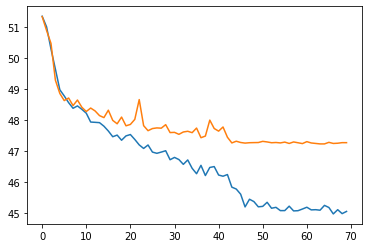

In [72]:
plt.plot([k[0] for k in hist])
plt.plot([k[1] for k in hist])

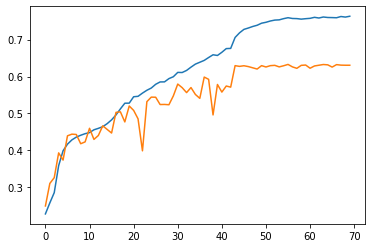

In [73]:
plt.plot([k[2] for k in hist])
plt.plot([k[3] for k in hist])

In [75]:
exp_features = []
exp_labels = []
_sims = []
_sims_labels = []

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs, sims, sims_labels, features, sims_loss = model(inputs, labels)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())
        _sims.append(sims.detach().cpu())
        _sims_labels.append(sims_labels.detach().cpu())

#     sims_loss = sims_criterion(sims, sims_labels)
    loss = criterion(outputs, labels) + sims_loss
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. test_loss: %.4f | Avg. test_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. test_loss: 46.2400 | Avg. test_acc: 0.6347


In [76]:
exp_features = torch.cat(exp_features, axis=0)
exp_labels = torch.cat(exp_labels)

exp_features.size()

torch.Size([3589, 512])

(<Figure size 1080x720 with 1 Axes>,
 array([[ 13.793558 ,   2.9434385],
        [  7.762442 ,  -7.40374  ],
        [ 10.345273 ,  12.718691 ],
        ...,
        [ 15.292585 ,   3.2206068],
        [  9.137995 , -21.875349 ],
        [ 22.30837  ,   5.722502 ]], dtype=float32))

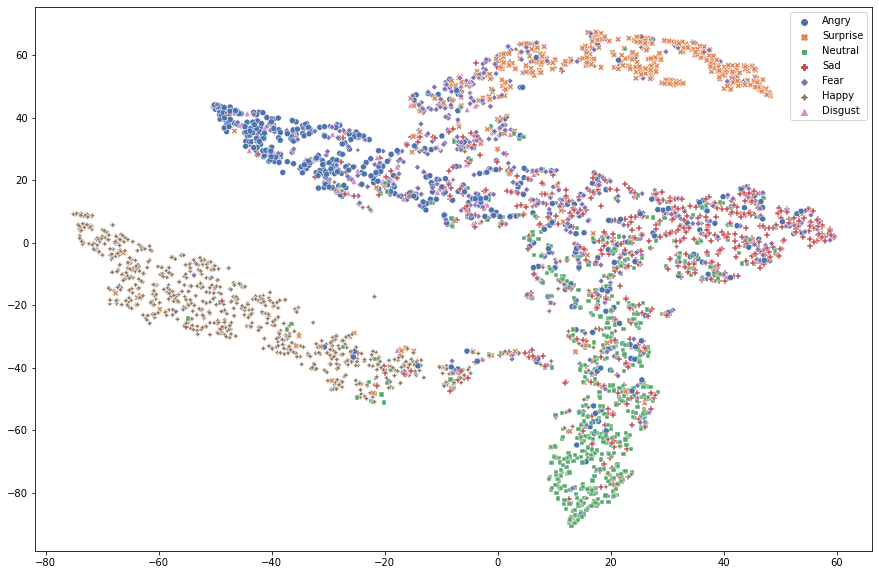

In [77]:
visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path=None)

In [121]:
model_path = None
epochs = 50
# train
best_acc = 0.0
curloss = -1
hist = []

for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_simloss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

#             print('Unique labels: ', torch.unique(labels))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sims, sims_labels, features, sims_loss = model(inputs, labels)
        
#         sims_loss = sims_criterion(sims, sims_labels)
        loss = criterion(outputs, labels) + sims_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_simloss += (sims_loss.item() * inputs.size((0)))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Simloss={sims_loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')
    
    print('- Avg.loss: %.4f | Avg.sims_loss: %.4f |Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_simloss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)
    
    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valsimloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sims, sims_labels, features, sims_loss = model(inputs, labels)

#         sims_loss = sims_criterion(sims, sims_labels)
        loss = criterion(outputs, labels) + sims_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valsimloss += (sims_loss.item() * inputs.size((0)))
        running_valacc += acc.item()

    print('- Avg. test_loss: %.4f | Avg. test_sims_loss: %4f | Avg. test_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valsimloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)

    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])

    if best_acc < avgvalacc:
        best_acc = avgvalacc
        curloss = avgvalloss
        if model_path is not None:
            torch.save(model, model_path)
        print('* Update optimal model')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=26.107866287231445 Simloss=24.495079040527344 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [00:16<00:00, 13.61it/s]

- Avg.loss: 113.1324 | Avg.sims_loss: 111.4071 |Avg.acc: 0.2941



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 113.9311 | Avg. test_sims_loss: 111.513591 | Avg. test_acc: 0.2639
* Update optimal model
Epoch:  2


Loss=26.60138702392578 Simloss=25.393491744995117 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:16<00:00, 13.58it/s]

- Avg.loss: 110.6817 | Avg.sims_loss: 109.2043 |Avg.acc: 0.4147



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 110.4416 | Avg. test_sims_loss: 108.982512 | Avg. test_acc: 0.4235
* Update optimal model
Epoch:  3


Loss=27.064361572265625 Simloss=25.50953483581543 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:16<00:00, 13.55it/s]

- Avg.loss: 109.8679 | Avg.sims_loss: 108.4653 |Avg.acc: 0.4469



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 110.1305 | Avg. test_sims_loss: 108.656490 | Avg. test_acc: 0.4257
* Update optimal model
Epoch:  4


Loss=30.51177406311035 Simloss=29.26540184020996 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:16<00:00, 13.55it/s]

- Avg.loss: 109.3793 | Avg.sims_loss: 108.0153 |Avg.acc: 0.4632



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 108.8511 | Avg. test_sims_loss: 107.532961 | Avg. test_acc: 0.4737
* Update optimal model
Epoch:  5


Loss=25.26116371154785 Simloss=23.967161178588867 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:16<00:00, 13.54it/s]

- Avg.loss: 108.6918 | Avg.sims_loss: 107.3663 |Avg.acc: 0.4801



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 109.2740 | Avg. test_sims_loss: 107.661617 | Avg. test_acc: 0.4363
Epoch:  6


Loss=29.510026931762695 Simloss=27.88881492614746 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [00:16<00:00, 13.43it/s]

- Avg.loss: 108.5761 | Avg.sims_loss: 107.2611 |Avg.acc: 0.4820



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 108.5408 | Avg. test_sims_loss: 107.217966 | Avg. test_acc: 0.4731
Epoch:  7


Loss=23.812482833862305 Simloss=22.737646102905273 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:16<00:00, 13.45it/s]

- Avg.loss: 108.3359 | Avg.sims_loss: 107.0445 |Avg.acc: 0.4937



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 108.9597 | Avg. test_sims_loss: 107.628777 | Avg. test_acc: 0.4731
Epoch:  8


Loss=28.156320571899414 Simloss=26.431520462036133 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [00:16<00:00, 13.47it/s]

- Avg.loss: 108.3408 | Avg.sims_loss: 107.0635 |Avg.acc: 0.5046



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 108.2539 | Avg. test_sims_loss: 106.985189 | Avg. test_acc: 0.5071
* Update optimal model
Epoch:  9


Loss=23.392452239990234 Simloss=22.314237594604492 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:16<00:00, 13.47it/s]

- Avg.loss: 107.8366 | Avg.sims_loss: 106.5854 |Avg.acc: 0.5171



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 108.3541 | Avg. test_sims_loss: 107.095416 | Avg. test_acc: 0.5118
* Update optimal model
Epoch:  10


Loss=23.965572357177734 Simloss=22.81281280517578 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:16<00:00, 13.45it/s]

- Avg.loss: 107.7131 | Avg.sims_loss: 106.4832 |Avg.acc: 0.5250



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 108.3596 | Avg. test_sims_loss: 107.118424 | Avg. test_acc: 0.5110
Epoch:  11


Loss=27.160364151000977 Simloss=26.116729736328125 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:16<00:00, 13.43it/s]

- Avg.loss: 107.5363 | Avg.sims_loss: 106.3322 |Avg.acc: 0.5383



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 108.4964 | Avg. test_sims_loss: 107.153954 | Avg. test_acc: 0.5152
* Update optimal model
Epoch:  12


Loss=27.939485549926758 Simloss=26.979129791259766 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:16<00:00, 13.44it/s]

- Avg.loss: 107.3881 | Avg.sims_loss: 106.2057 |Avg.acc: 0.5451



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.8572 | Avg. test_sims_loss: 106.583442 | Avg. test_acc: 0.4990
Epoch:  13


Loss=25.720205307006836 Simloss=24.67665672302246 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:16<00:00, 13.41it/s]

- Avg.loss: 107.3354 | Avg.sims_loss: 106.1769 |Avg.acc: 0.5612



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 108.0882 | Avg. test_sims_loss: 106.889984 | Avg. test_acc: 0.5428
* Update optimal model
Epoch:  14


Loss=24.96224594116211 Simloss=23.872684478759766 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:16<00:00, 13.37it/s]

- Avg.loss: 106.8868 | Avg.sims_loss: 105.7431 |Avg.acc: 0.5673



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.9722 | Avg. test_sims_loss: 106.757804 | Avg. test_acc: 0.5372
Epoch:  15


Loss=29.02092742919922 Simloss=27.756105422973633 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:16<00:00, 13.40it/s]

- Avg.loss: 106.7622 | Avg.sims_loss: 105.6317 |Avg.acc: 0.5754



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.8095 | Avg. test_sims_loss: 106.618323 | Avg. test_acc: 0.5366
Epoch:  16


Loss=22.06422233581543 Simloss=20.995813369750977 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:16<00:00, 13.41it/s]

- Avg.loss: 106.9236 | Avg.sims_loss: 105.8152 |Avg.acc: 0.5826



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.8659 | Avg. test_sims_loss: 106.716152 | Avg. test_acc: 0.5559
* Update optimal model
Epoch:  17


Loss=26.664669036865234 Simloss=25.56756019592285 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:16<00:00, 13.38it/s]

- Avg.loss: 106.8025 | Avg.sims_loss: 105.7005 |Avg.acc: 0.5861



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 108.9956 | Avg. test_sims_loss: 107.691352 | Avg. test_acc: 0.5015
Epoch:  18


Loss=26.235200881958008 Simloss=24.976390838623047 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:16<00:00, 13.39it/s]

- Avg.loss: 106.3878 | Avg.sims_loss: 105.2948 |Avg.acc: 0.5931



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.6911 | Avg. test_sims_loss: 106.495353 | Avg. test_acc: 0.5425
Epoch:  19


Loss=26.107498168945312 Simloss=25.0738525390625 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:16<00:00, 13.42it/s]

- Avg.loss: 106.1158 | Avg.sims_loss: 105.0403 |Avg.acc: 0.5997



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.6661 | Avg. test_sims_loss: 106.503345 | Avg. test_acc: 0.5612
* Update optimal model
Epoch:  20


Loss=25.04600715637207 Simloss=23.886728286743164 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:16<00:00, 13.41it/s]

- Avg.loss: 106.2221 | Avg.sims_loss: 105.1664 |Avg.acc: 0.6085



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.4744 | Avg. test_sims_loss: 106.315543 | Avg. test_acc: 0.5804
* Update optimal model
Epoch:  21


Loss=25.533931732177734 Simloss=24.18062400817871 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:16<00:00, 13.40it/s]

- Avg.loss: 105.9006 | Avg.sims_loss: 104.8570 |Avg.acc: 0.6189



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 108.0198 | Avg. test_sims_loss: 106.758362 | Avg. test_acc: 0.5263
Epoch:  22


Loss=22.945837020874023 Simloss=21.858314514160156 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:16<00:00, 13.39it/s]

- Avg.loss: 106.0377 | Avg.sims_loss: 104.9993 |Avg.acc: 0.6210



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.5696 | Avg. test_sims_loss: 106.408365 | Avg. test_acc: 0.5765
Epoch:  23


Loss=26.656726837158203 Simloss=25.373802185058594 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:16<00:00, 13.39it/s]

- Avg.loss: 105.9789 | Avg.sims_loss: 104.9540 |Avg.acc: 0.6256



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.4256 | Avg. test_sims_loss: 106.297694 | Avg. test_acc: 0.5837
* Update optimal model
Epoch:  24


Loss=22.96643829345703 Simloss=21.937213897705078 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:16<00:00, 13.40it/s]

- Avg.loss: 106.1753 | Avg.sims_loss: 105.1563 |Avg.acc: 0.6313



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.8261 | Avg. test_sims_loss: 106.639556 | Avg. test_acc: 0.5656
Epoch:  25


Loss=25.32093620300293 Simloss=24.43110466003418 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:16<00:00, 13.41it/s]

- Avg.loss: 105.4672 | Avg.sims_loss: 104.4647 |Avg.acc: 0.6352



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.8969 | Avg. test_sims_loss: 106.711696 | Avg. test_acc: 0.5723
Epoch:  26


Loss=23.76641273498535 Simloss=22.6289119720459 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:16<00:00, 13.37it/s]

- Avg.loss: 105.5149 | Avg.sims_loss: 104.5259 |Avg.acc: 0.6411



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.1326 | Avg. test_sims_loss: 106.050259 | Avg. test_acc: 0.5974
* Update optimal model
Epoch:  27


Loss=21.99846076965332 Simloss=21.238039016723633 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:16<00:00, 13.37it/s]

- Avg.loss: 105.4497 | Avg.sims_loss: 104.4652 |Avg.acc: 0.6427



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.5043 | Avg. test_sims_loss: 106.326006 | Avg. test_acc: 0.5637
Epoch:  28


Loss=32.18961715698242 Simloss=31.282512664794922 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:16<00:00, 13.41it/s]

- Avg.loss: 105.3469 | Avg.sims_loss: 104.3731 |Avg.acc: 0.6520



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.5673 | Avg. test_sims_loss: 106.384060 | Avg. test_acc: 0.5673
Epoch:  29


Loss=26.46473503112793 Simloss=25.609455108642578 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:16<00:00, 13.37it/s]

- Avg.loss: 105.5701 | Avg.sims_loss: 104.6019 |Avg.acc: 0.6551



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.2301 | Avg. test_sims_loss: 106.138335 | Avg. test_acc: 0.5954
Epoch:  30


Loss=26.136699676513672 Simloss=24.472015380859375 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:16<00:00, 13.34it/s]

- Avg.loss: 105.3777 | Avg.sims_loss: 104.4252 |Avg.acc: 0.6612



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.2014 | Avg. test_sims_loss: 106.096074 | Avg. test_acc: 0.6030
* Update optimal model
Epoch:  31


Loss=24.63286590576172 Simloss=23.938020706176758 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:16<00:00, 13.37it/s]

- Avg.loss: 105.2885 | Avg.sims_loss: 104.3512 |Avg.acc: 0.6709



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.4587 | Avg. test_sims_loss: 106.319772 | Avg. test_acc: 0.5857
Epoch:  32


Loss=22.66303253173828 Simloss=21.779129028320312 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:16<00:00, 13.38it/s]

- Avg.loss: 105.0540 | Avg.sims_loss: 104.1236 |Avg.acc: 0.6725



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.1028 | Avg. test_sims_loss: 106.032213 | Avg. test_acc: 0.6141
* Update optimal model
Epoch:  33


Loss=27.568519592285156 Simloss=26.615802764892578 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:16<00:00, 13.42it/s]

- Avg.loss: 104.9676 | Avg.sims_loss: 104.0485 |Avg.acc: 0.6809



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.2346 | Avg. test_sims_loss: 106.129184 | Avg. test_acc: 0.6027
Epoch:  34


Loss=26.21466064453125 Simloss=25.39515495300293 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:16<00:00, 13.34it/s]

- Avg.loss: 104.7538 | Avg.sims_loss: 103.8498 |Avg.acc: 0.6855



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.4141 | Avg. test_sims_loss: 106.250130 | Avg. test_acc: 0.5910
Epoch:  35


Loss=24.54818344116211 Simloss=23.530677795410156 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:16<00:00, 13.38it/s]

- Avg.loss: 105.0418 | Avg.sims_loss: 104.1502 |Avg.acc: 0.6897



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.6483 | Avg. test_sims_loss: 106.515295 | Avg. test_acc: 0.5993
Epoch:  36


Loss=25.87041473388672 Simloss=25.189834594726562 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:16<00:00, 13.37it/s]

- Avg.loss: 104.3505 | Avg.sims_loss: 103.4677 |Avg.acc: 0.6950



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.3242 | Avg. test_sims_loss: 106.243380 | Avg. test_acc: 0.6149
* Update optimal model
Epoch:  37


Loss=21.551021575927734 Simloss=20.637065887451172 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:16<00:00, 13.40it/s]

- Avg.loss: 104.5403 | Avg.sims_loss: 103.6617 |Avg.acc: 0.6974



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.2421 | Avg. test_sims_loss: 106.079049 | Avg. test_acc: 0.5915
Epoch:  38


Loss=22.320756912231445 Simloss=21.509828567504883 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:16<00:00, 13.38it/s]

- Avg.loss: 104.5678 | Avg.sims_loss: 103.7049 |Avg.acc: 0.7009



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.1705 | Avg. test_sims_loss: 106.077513 | Avg. test_acc: 0.6105
Epoch    38: reducing learning rate of group 0 to 5.0000e-05.
Epoch:  39


Loss=22.487281799316406 Simloss=21.769926071166992 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:16<00:00, 13.35it/s]

- Avg.loss: 103.8139 | Avg.sims_loss: 103.0122 |Avg.acc: 0.7307



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.8929 | Avg. test_sims_loss: 105.838495 | Avg. test_acc: 0.6434
* Update optimal model
Epoch:  40


Loss=24.68255615234375 Simloss=24.071317672729492 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:16<00:00, 13.36it/s]

- Avg.loss: 103.2996 | Avg.sims_loss: 102.5305 |Avg.acc: 0.7429



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.9696 | Avg. test_sims_loss: 105.913262 | Avg. test_acc: 0.6347
Epoch:  41


Loss=26.149534225463867 Simloss=25.46149444580078 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:16<00:00, 13.33it/s]

- Avg.loss: 103.4346 | Avg.sims_loss: 102.6763 |Avg.acc: 0.7498



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.0153 | Avg. test_sims_loss: 105.937227 | Avg. test_acc: 0.6372
Epoch:  42


Loss=25.518291473388672 Simloss=24.580604553222656 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:16<00:00, 13.36it/s]

- Avg.loss: 103.1255 | Avg.sims_loss: 102.3805 |Avg.acc: 0.7542



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.9678 | Avg. test_sims_loss: 105.879700 | Avg. test_acc: 0.6333
Epoch:  43


Loss=23.656118392944336 Simloss=23.0905704498291 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:16<00:00, 13.31it/s]

- Avg.loss: 103.0842 | Avg.sims_loss: 102.3467 |Avg.acc: 0.7552



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.9144 | Avg. test_sims_loss: 105.842331 | Avg. test_acc: 0.6386
Epoch:  44


Loss=28.250205993652344 Simloss=27.695642471313477 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:16<00:00, 13.37it/s]

- Avg.loss: 102.8719 | Avg.sims_loss: 102.1374 |Avg.acc: 0.7578



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.9829 | Avg. test_sims_loss: 105.907711 | Avg. test_acc: 0.6386
Epoch:  45


Loss=36.1019401550293 Simloss=35.43497848510742 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:16<00:00, 13.37it/s]

- Avg.loss: 102.7445 | Avg.sims_loss: 102.0177 |Avg.acc: 0.7614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.9865 | Avg. test_sims_loss: 105.912999 | Avg. test_acc: 0.6406
Epoch    45: reducing learning rate of group 0 to 5.0000e-06.
Epoch:  46


Loss=25.34046745300293 Simloss=24.67005157470703 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:16<00:00, 13.36it/s]

- Avg.loss: 103.1322 | Avg.sims_loss: 102.4043 |Avg.acc: 0.7625



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.9364 | Avg. test_sims_loss: 105.859486 | Avg. test_acc: 0.6425
Epoch:  47


Loss=22.51011085510254 Simloss=21.946941375732422 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:16<00:00, 13.35it/s]

- Avg.loss: 102.8436 | Avg.sims_loss: 102.1234 |Avg.acc: 0.7648



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.9334 | Avg. test_sims_loss: 105.859125 | Avg. test_acc: 0.6417
Epoch:  48


Loss=24.72477912902832 Simloss=24.022197723388672 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:16<00:00, 13.39it/s]

- Avg.loss: 102.7595 | Avg.sims_loss: 102.0463 |Avg.acc: 0.7675



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.9172 | Avg. test_sims_loss: 105.842416 | Avg. test_acc: 0.6414
Epoch:  49


Loss=24.17617416381836 Simloss=23.507856369018555 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:16<00:00, 13.34it/s]

- Avg.loss: 102.8711 | Avg.sims_loss: 102.1580 |Avg.acc: 0.7671



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.9543 | Avg. test_sims_loss: 105.872080 | Avg. test_acc: 0.6383
Epoch:  50


Loss=21.60540008544922 Simloss=21.07643699645996 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:16<00:00, 13.33it/s]

- Avg.loss: 102.9648 | Avg.sims_loss: 102.2529 |Avg.acc: 0.7678


- Avg. test_loss: 106.9452 | Avg. test_sims_loss: 105.866550 | Avg. test_acc: 0.6400


In [122]:
exp_features = []
exp_labels = []
_sims = []
_sims_labels = []

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs, sims, sims_labels, features, sims_loss = model(inputs, labels)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())
        _sims.append(sims.detach().cpu())
        _sims_labels.append(sims_labels.detach().cpu())

#     sims_loss = sims_criterion(sims, sims_labels)
    loss = criterion(outputs, labels) + sims_loss
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. test_loss: %.4f | Avg. test_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. test_loss: 105.8943 | Avg. test_acc: 0.6528


In [123]:
exp_features = torch.cat(exp_features, axis=0)
exp_labels = torch.cat(exp_labels)

exp_features.size()

torch.Size([3589, 512])

(<Figure size 1080x720 with 1 Axes>,
 array([[-39.257446 , -21.86741  ],
        [  2.2529724, -15.110494 ],
        [-33.05183  , -29.265745 ],
        ...,
        [  7.5253677,   8.11787  ],
        [ 19.328432 ,  63.858585 ],
        [  7.466781 ,   8.103862 ]], dtype=float32))

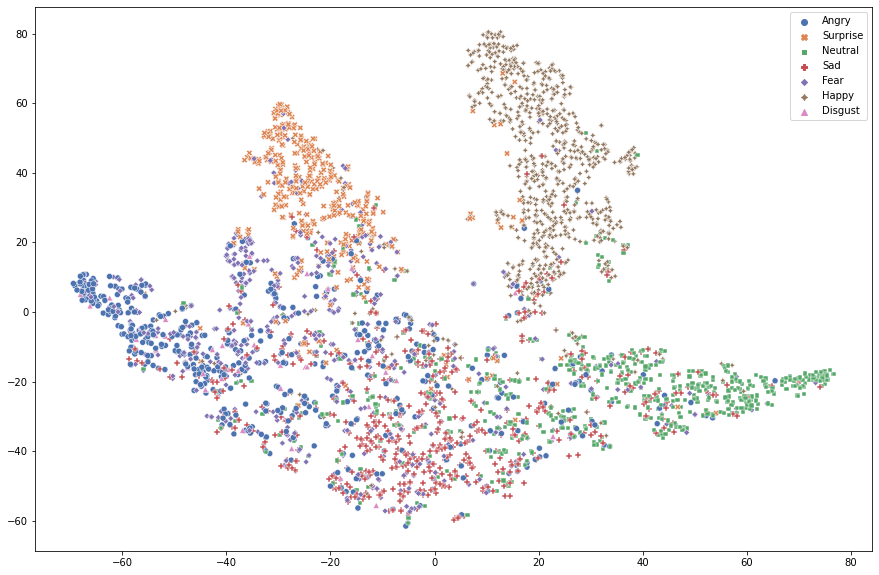

In [124]:
visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path=None)

In [134]:
model_path = None
epochs = 50
# train
best_acc = 0.0
curloss = -1
hist = []

for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_simloss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

#             print('Unique labels: ', torch.unique(labels))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sims, sims_labels, features, sims_loss = model(inputs, labels)
        
#         sims_loss = sims_criterion(sims, sims_labels)
        loss = criterion(outputs, labels) + sims_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_simloss += (sims_loss.item() * inputs.size((0)))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Simloss={sims_loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')
    
    print('- Avg.loss: %.4f | Avg.sims_loss: %.4f |Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_simloss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)
    
    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valsimloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sims, sims_labels, features, sims_loss = model(inputs, labels)

#         sims_loss = sims_criterion(sims, sims_labels)
        loss = criterion(outputs, labels) + sims_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valsimloss += (sims_loss.item() * inputs.size((0)))
        running_valacc += acc.item()

    print('- Avg. test_loss: %.4f | Avg. test_sims_loss: %4f | Avg. test_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valsimloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)

    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])

    if best_acc < avgvalacc:
        best_acc = avgvalacc
        curloss = avgvalloss
        if model_path is not None:
            torch.save(model, model_path)
        print('* Update optimal model')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=27.324148178100586 Simloss=25.999526977539062 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:16<00:00, 13.63it/s]

- Avg.loss: 111.1279 | Avg.sims_loss: 109.5891 |Avg.acc: 0.3923



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 111.3363 | Avg. test_sims_loss: 108.154302 | Avg. test_acc: 0.3341
* Update optimal model
Epoch:  2


Loss=23.506296157836914 Simloss=22.118877410888672 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:16<00:00, 13.65it/s]

- Avg.loss: 109.1959 | Avg.sims_loss: 107.8636 |Avg.acc: 0.4890



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 108.8101 | Avg. test_sims_loss: 107.324158 | Avg. test_acc: 0.4667
* Update optimal model
Epoch:  3


Loss=26.515230178833008 Simloss=25.37488555908203 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:16<00:00, 13.58it/s]

- Avg.loss: 108.1119 | Avg.sims_loss: 106.8582 |Avg.acc: 0.5283



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 108.3585 | Avg. test_sims_loss: 106.712209 | Avg. test_acc: 0.4583
Epoch:  4


Loss=27.801652908325195 Simloss=26.824758529663086 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:16<00:00, 13.58it/s]

- Avg.loss: 107.6267 | Avg.sims_loss: 106.4309 |Avg.acc: 0.5503



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 108.0013 | Avg. test_sims_loss: 106.589380 | Avg. test_acc: 0.4896
* Update optimal model
Epoch:  5


Loss=27.86800193786621 Simloss=26.503995895385742 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:16<00:00, 13.57it/s]

- Avg.loss: 107.1977 | Avg.sims_loss: 106.0441 |Avg.acc: 0.5695



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 108.1209 | Avg. test_sims_loss: 106.733933 | Avg. test_acc: 0.4879
Epoch:  6


Loss=26.321685791015625 Simloss=25.344179153442383 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:16<00:00, 13.55it/s]

- Avg.loss: 107.0214 | Avg.sims_loss: 105.8963 |Avg.acc: 0.5803



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.9331 | Avg. test_sims_loss: 106.540861 | Avg. test_acc: 0.5216
* Update optimal model
Epoch:  7


Loss=26.408803939819336 Simloss=25.341543197631836 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:16<00:00, 13.53it/s]

- Avg.loss: 106.7603 | Avg.sims_loss: 105.6626 |Avg.acc: 0.5921



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.5897 | Avg. test_sims_loss: 106.252911 | Avg. test_acc: 0.5283
* Update optimal model
Epoch:  8


Loss=33.2202033996582 Simloss=32.306575775146484 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:16<00:00, 13.46it/s]

- Avg.loss: 106.4872 | Avg.sims_loss: 105.4179 |Avg.acc: 0.6068



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.4472 | Avg. test_sims_loss: 106.060305 | Avg. test_acc: 0.5297
* Update optimal model
Epoch:  9


Loss=23.044883728027344 Simloss=21.901920318603516 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:16<00:00, 13.49it/s]

- Avg.loss: 106.0923 | Avg.sims_loss: 105.0458 |Avg.acc: 0.6241



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.6734 | Avg. test_sims_loss: 106.371318 | Avg. test_acc: 0.5534
* Update optimal model
Epoch:  10


Loss=27.07622528076172 Simloss=26.082439422607422 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:16<00:00, 13.45it/s]

- Avg.loss: 106.2272 | Avg.sims_loss: 105.1976 |Avg.acc: 0.6282



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.3485 | Avg. test_sims_loss: 106.136684 | Avg. test_acc: 0.5656
* Update optimal model
Epoch:  11


Loss=23.92706871032715 Simloss=22.900270462036133 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:16<00:00, 13.49it/s]

- Avg.loss: 106.1497 | Avg.sims_loss: 105.1404 |Avg.acc: 0.6409



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.6177 | Avg. test_sims_loss: 106.192420 | Avg. test_acc: 0.4926
Epoch:  12


Loss=21.335935592651367 Simloss=20.401403427124023 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:16<00:00, 13.41it/s]

- Avg.loss: 105.6047 | Avg.sims_loss: 104.6112 |Avg.acc: 0.6465



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.7398 | Avg. test_sims_loss: 106.411007 | Avg. test_acc: 0.5247
Epoch:  13


Loss=24.26148223876953 Simloss=23.047876358032227 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:16<00:00, 13.47it/s]

- Avg.loss: 105.5787 | Avg.sims_loss: 104.6060 |Avg.acc: 0.6599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.5015 | Avg. test_sims_loss: 106.131498 | Avg. test_acc: 0.5336
Epoch:  14


Loss=23.429262161254883 Simloss=22.20097541809082 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:16<00:00, 13.46it/s]

- Avg.loss: 105.0554 | Avg.sims_loss: 104.1090 |Avg.acc: 0.6694



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.0674 | Avg. test_sims_loss: 105.887490 | Avg. test_acc: 0.5982
* Update optimal model
Epoch:  15


Loss=25.352279663085938 Simloss=24.294971466064453 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:16<00:00, 13.47it/s]

- Avg.loss: 104.8468 | Avg.sims_loss: 103.9207 |Avg.acc: 0.6798



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.7715 | Avg. test_sims_loss: 105.552614 | Avg. test_acc: 0.6102
* Update optimal model
Epoch:  16


Loss=26.36925506591797 Simloss=25.170555114746094 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:16<00:00, 13.41it/s]

- Avg.loss: 104.8564 | Avg.sims_loss: 103.9533 |Avg.acc: 0.6909



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.3721 | Avg. test_sims_loss: 106.119554 | Avg. test_acc: 0.5832
Epoch:  17


Loss=27.56659507751465 Simloss=26.829730987548828 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:16<00:00, 13.48it/s]

- Avg.loss: 104.7497 | Avg.sims_loss: 103.8646 |Avg.acc: 0.6960



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.0201 | Avg. test_sims_loss: 105.860743 | Avg. test_acc: 0.6130
* Update optimal model
Epoch:  18


Loss=23.512405395507812 Simloss=22.538589477539062 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:16<00:00, 13.45it/s]

- Avg.loss: 104.4346 | Avg.sims_loss: 103.5694 |Avg.acc: 0.7083



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.2248 | Avg. test_sims_loss: 105.873225 | Avg. test_acc: 0.5787
Epoch:  19


Loss=23.943466186523438 Simloss=23.183982849121094 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:16<00:00, 13.45it/s]

- Avg.loss: 104.1853 | Avg.sims_loss: 103.3283 |Avg.acc: 0.7151



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.9093 | Avg. test_sims_loss: 105.692129 | Avg. test_acc: 0.6124
Epoch:  20


Loss=23.886066436767578 Simloss=22.925128936767578 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:16<00:00, 13.45it/s]

- Avg.loss: 103.9211 | Avg.sims_loss: 103.0861 |Avg.acc: 0.7252



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.1492 | Avg. test_sims_loss: 105.754174 | Avg. test_acc: 0.5882
Epoch:  21


Loss=23.624696731567383 Simloss=23.020605087280273 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:16<00:00, 13.42it/s]

- Avg.loss: 103.7186 | Avg.sims_loss: 102.9034 |Avg.acc: 0.7313



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.3757 | Avg. test_sims_loss: 106.006065 | Avg. test_acc: 0.6046
Epoch    21: reducing learning rate of group 0 to 5.0000e-05.
Epoch:  22


Loss=25.254192352294922 Simloss=24.59275245666504 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:16<00:00, 13.35it/s]

- Avg.loss: 102.9643 | Avg.sims_loss: 102.2205 |Avg.acc: 0.7580



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.6706 | Avg. test_sims_loss: 105.562096 | Avg. test_acc: 0.6414
* Update optimal model
Epoch:  23


Loss=22.56682777404785 Simloss=21.627548217773438 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:16<00:00, 13.43it/s]

- Avg.loss: 102.7165 | Avg.sims_loss: 102.0089 |Avg.acc: 0.7752



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.6688 | Avg. test_sims_loss: 105.548092 | Avg. test_acc: 0.6495
* Update optimal model
Epoch:  24


Loss=25.115127563476562 Simloss=24.593814849853516 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:16<00:00, 13.40it/s]

- Avg.loss: 102.7639 | Avg.sims_loss: 102.0757 |Avg.acc: 0.7815



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.5674 | Avg. test_sims_loss: 105.454779 | Avg. test_acc: 0.6520
* Update optimal model
Epoch:  25


Loss=22.142162322998047 Simloss=21.120908737182617 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:16<00:00, 13.41it/s]

- Avg.loss: 102.6668 | Avg.sims_loss: 101.9892 |Avg.acc: 0.7886



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.5947 | Avg. test_sims_loss: 105.463915 | Avg. test_acc: 0.6520
Epoch:  26


Loss=24.288705825805664 Simloss=23.69422721862793 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:16<00:00, 13.38it/s]

- Avg.loss: 102.2804 | Avg.sims_loss: 101.6146 |Avg.acc: 0.7918



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.6255 | Avg. test_sims_loss: 105.503976 | Avg. test_acc: 0.6534
* Update optimal model
Epoch:  27


Loss=24.327922821044922 Simloss=23.63805389404297 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:16<00:00, 13.41it/s]

- Avg.loss: 102.5449 | Avg.sims_loss: 101.8879 |Avg.acc: 0.7942



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.6941 | Avg. test_sims_loss: 105.554004 | Avg. test_acc: 0.6503
Epoch:  28


Loss=23.915639877319336 Simloss=23.11670684814453 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:16<00:00, 13.41it/s]

- Avg.loss: 102.1573 | Avg.sims_loss: 101.5088 |Avg.acc: 0.7980



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.6220 | Avg. test_sims_loss: 105.492162 | Avg. test_acc: 0.6578
* Update optimal model
Epoch:  29


Loss=21.41941261291504 Simloss=20.52875518798828 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:16<00:00, 13.39it/s]

- Avg.loss: 102.4997 | Avg.sims_loss: 101.8595 |Avg.acc: 0.8030



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.7535 | Avg. test_sims_loss: 105.616530 | Avg. test_acc: 0.6553
Epoch:  30


Loss=28.08010482788086 Simloss=27.415756225585938 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:16<00:00, 13.39it/s]

- Avg.loss: 102.1460 | Avg.sims_loss: 101.5137 |Avg.acc: 0.8050



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.6681 | Avg. test_sims_loss: 105.518470 | Avg. test_acc: 0.6548
Epoch    30: reducing learning rate of group 0 to 5.0000e-06.
Epoch:  31


Loss=24.095993041992188 Simloss=23.434965133666992 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:16<00:00, 13.46it/s]

- Avg.loss: 101.5860 | Avg.sims_loss: 100.9673 |Avg.acc: 0.8111



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.6552 | Avg. test_sims_loss: 105.523583 | Avg. test_acc: 0.6562
Epoch:  32


Loss=22.447900772094727 Simloss=21.679235458374023 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:16<00:00, 13.43it/s]

- Avg.loss: 101.8952 | Avg.sims_loss: 101.2796 |Avg.acc: 0.8113



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.6385 | Avg. test_sims_loss: 105.494459 | Avg. test_acc: 0.6578
Epoch:  33


Loss=23.006866455078125 Simloss=22.276283264160156 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:16<00:00, 13.41it/s]

- Avg.loss: 101.8328 | Avg.sims_loss: 101.2114 |Avg.acc: 0.8123



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.6499 | Avg. test_sims_loss: 105.499024 | Avg. test_acc: 0.6545
Epoch:  34


Loss=26.99529457092285 Simloss=26.366979598999023 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:16<00:00, 13.38it/s]

- Avg.loss: 101.7774 | Avg.sims_loss: 101.1621 |Avg.acc: 0.8124



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.6527 | Avg. test_sims_loss: 105.518263 | Avg. test_acc: 0.6548
Epoch:  35


Loss=22.81378746032715 Simloss=22.004610061645508 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:16<00:00, 13.40it/s]

- Avg.loss: 101.9094 | Avg.sims_loss: 101.2925 |Avg.acc: 0.8104



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.6312 | Avg. test_sims_loss: 105.499240 | Avg. test_acc: 0.6565
Epoch:  36


Loss=20.450681686401367 Simloss=20.037500381469727 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:16<00:00, 13.39it/s]

- Avg.loss: 101.6644 | Avg.sims_loss: 101.0487 |Avg.acc: 0.8133



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.5799 | Avg. test_sims_loss: 105.462225 | Avg. test_acc: 0.6601
Epoch    36: reducing learning rate of group 0 to 5.0000e-07.
* Update optimal model
Epoch:  37


Loss=23.2020263671875 Simloss=22.627487182617188 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:16<00:00, 13.40it/s]

- Avg.loss: 101.6627 | Avg.sims_loss: 101.0528 |Avg.acc: 0.8136



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.6448 | Avg. test_sims_loss: 105.511034 | Avg. test_acc: 0.6590
Epoch:  38


Loss=25.898820877075195 Simloss=25.492467880249023 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:16<00:00, 13.38it/s]

- Avg.loss: 101.9058 | Avg.sims_loss: 101.2950 |Avg.acc: 0.8130



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.6342 | Avg. test_sims_loss: 105.503258 | Avg. test_acc: 0.6587
Epoch:  39


Loss=21.760339736938477 Simloss=21.067079544067383 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:16<00:00, 13.37it/s]

- Avg.loss: 101.8146 | Avg.sims_loss: 101.2001 |Avg.acc: 0.8128



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.5572 | Avg. test_sims_loss: 105.444345 | Avg. test_acc: 0.6604
* Update optimal model
Epoch:  40


Loss=21.871536254882812 Simloss=21.32339096069336 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:16<00:00, 13.37it/s]

- Avg.loss: 101.9758 | Avg.sims_loss: 101.3617 |Avg.acc: 0.8140



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.6079 | Avg. test_sims_loss: 105.479396 | Avg. test_acc: 0.6601
Epoch:  41


Loss=24.67119026184082 Simloss=23.921175003051758 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:16<00:00, 13.39it/s]

- Avg.loss: 101.8308 | Avg.sims_loss: 101.2164 |Avg.acc: 0.8131



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.6010 | Avg. test_sims_loss: 105.468128 | Avg. test_acc: 0.6578
Epoch:  42


Loss=23.826766967773438 Simloss=23.283370971679688 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:16<00:00, 13.35it/s]

- Avg.loss: 101.6754 | Avg.sims_loss: 101.0671 |Avg.acc: 0.8161



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.5855 | Avg. test_sims_loss: 105.467775 | Avg. test_acc: 0.6587
Epoch    42: reducing learning rate of group 0 to 5.0000e-08.
Epoch:  43


Loss=22.286556243896484 Simloss=21.798954010009766 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:16<00:00, 13.39it/s]

- Avg.loss: 101.8260 | Avg.sims_loss: 101.2143 |Avg.acc: 0.8129



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.6551 | Avg. test_sims_loss: 105.507379 | Avg. test_acc: 0.6598
Epoch:  44


Loss=20.756948471069336 Simloss=20.348552703857422 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:16<00:00, 13.40it/s]

- Avg.loss: 101.7538 | Avg.sims_loss: 101.1396 |Avg.acc: 0.8123



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.6220 | Avg. test_sims_loss: 105.495594 | Avg. test_acc: 0.6576
Epoch:  45


Loss=22.21038055419922 Simloss=21.380319595336914 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:16<00:00, 13.37it/s]

- Avg.loss: 101.7247 | Avg.sims_loss: 101.1165 |Avg.acc: 0.8154



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.6873 | Avg. test_sims_loss: 105.528344 | Avg. test_acc: 0.6570
Epoch:  46


Loss=21.396991729736328 Simloss=21.004608154296875 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:16<00:00, 13.39it/s]

- Avg.loss: 101.9401 | Avg.sims_loss: 101.3282 |Avg.acc: 0.8131



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.7088 | Avg. test_sims_loss: 105.546488 | Avg. test_acc: 0.6517
Epoch:  47


Loss=23.28564453125 Simloss=22.832666397094727 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:16<00:00, 13.40it/s]

- Avg.loss: 101.5846 | Avg.sims_loss: 100.9727 |Avg.acc: 0.8134



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.6538 | Avg. test_sims_loss: 105.515467 | Avg. test_acc: 0.6576
Epoch:  48


Loss=21.767257690429688 Simloss=21.2415771484375 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:16<00:00, 13.35it/s]

- Avg.loss: 101.8899 | Avg.sims_loss: 101.2715 |Avg.acc: 0.8116



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.5879 | Avg. test_sims_loss: 105.459026 | Avg. test_acc: 0.6604
Epoch    48: reducing learning rate of group 0 to 5.0000e-09.
Epoch:  49


Loss=23.475704193115234 Simloss=23.000303268432617 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:16<00:00, 13.37it/s]

- Avg.loss: 101.7548 | Avg.sims_loss: 101.1416 |Avg.acc: 0.8143



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.5996 | Avg. test_sims_loss: 105.474382 | Avg. test_acc: 0.6570
Epoch:  50


Loss=21.131256103515625 Simloss=20.5523681640625 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:16<00:00, 13.37it/s]

- Avg.loss: 101.6249 | Avg.sims_loss: 101.0113 |Avg.acc: 0.8111


- Avg. test_loss: 106.6569 | Avg. test_sims_loss: 105.523134 | Avg. test_acc: 0.6587


# Loss func2

In [137]:
EPS = 1e-15
class ExpLoss(nn.Module):
    def __init__(self, depth, residual=True):
        super(ExpLoss, self).__init__()
        
        self.depth = depth
        self.residual = residual
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
        self.sims_logsoftmax = nn.Softmax(dim=1)
        
        self.proj1_in = nn.Sequential(nn.Linear(depth, depth),
                                 nn.BatchNorm1d(depth),
                                 nn.ReLU())
        self.proj2_in = nn.Sequential(nn.Linear(depth, depth),
                                 nn.BatchNorm1d(depth),
                                 nn.ReLU())
        
        self.proj1_out = nn.Sequential(nn.Linear(depth, depth),
                                 nn.BatchNorm1d(depth),
                                 nn.ReLU())
        self.proj2_out = nn.Sequential(nn.Linear(depth, depth),
                                 nn.BatchNorm1d(depth),
                                 nn.ReLU())
        
        self.out_fc = nn.Sequential(nn.Linear(depth, depth),
                                    nn.BatchNorm1d(depth),
                                    nn.ReLU())
        
    def forward(self, x, labels):
        batch_size = x.size(0)
        
        x = self.avgpool(x)
        x = self.flatten(x)
        
        if self.residual:
            x_res = x
        
        x = self.dropout(x)
        h1 = self.proj1_in(x)
        h2 = self.proj2_in(x)
        
        x1 = self.proj1_out(h1)
        x2 = self.proj2_out(h2)
        
        # normalize x1, x2
        x1 = x1 / x1.norm(dim=1)[:,None]
        x2 = x2 / x2.norm(dim=1)[:,None]
        
        # normalize z1, z2
#         h1 = h1 / h1.norm(dim=1)[:,None]
#         h2 = h2 / h2.norm(dim=1)[:,None]
        
        x = h1 + h2
        
        # cal sims (batchsize, depth)
        sims = torch.mm(x1, x2.permute(1,0))
        sims_act = self.sims_logsoftmax(sims)
        pos_sims_act = -torch.log(sims_act)
#         neg_sims_act = -torch.log(1-sims_act)
        
        mask_labels = self.filter_mask(labels)
        mask_labels = 1 - mask_labels # same labels as 1, different labels as 0
        mask_labels = mask_labels.to(labels.device)
        
        sims_loss = (pos_sims_act * mask_labels).sum(1).mean()
#         neg_sims_loss = (neg_sims_act * (1-mask_labels)).sum(1).mean()
        
        return x, sims, mask_labels, sims_loss, h1, h2 # sims.sigmoid() and mask_labels are used to cal BCELoss

    def filter_mask(self, labels):
        """
        mask zeroing them same
        """
        classes = torch.unique(labels)
        mask = torch.ones((len(labels), len(labels)))

        indices = [(labels == k).nonzero().flatten() for k in classes]
        lindices = [torch.combinations(k, r=2, with_replacement=True) for k in indices]
        rindices = [torch.combinations(k.flip(0), r=2, with_replacement=True) for k in indices]
        indices = [torch.cat([lindices[i], rindices[i]]) for i in range(len(lindices))]
        indices = [torch.unique(k, dim=0) for k in indices]

        for k in indices:
            mask[k[:,0], k[:,1]] = 0.

        spec_masks = []
        for k in indices:
            _temp = torch.zeros((len(labels), len(labels)))
            _temp[k[:,0], k[:,1]] = 1
            spec_masks.append(_temp)

        return mask

In [138]:
class sVGG_exp(nn.Module):
    def __init__(self, features, in_features_classifier, n_classes):
        super(sVGG_exp, self).__init__()
        self.features = features
        self.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.exploss = ExpLoss(512)
#         self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(in_features_classifier, in_features_classifier),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier, in_features_classifier // 2),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier // 2, n_classes))
        
    def forward(self, x, labels, return_att=True):
        x = self.features(x)
        att, sims, sims_labels, sims_loss, h1, h2 = self.exploss(x, labels)

#         att = self.avgpool(x)
        x = self.classifier(att)
        
        if return_att:
            return x, sims, sims_labels, att, sims_loss, h1, h2
        return x, sims, sims_labels, sims_loss, h1, h2
        

In [139]:
from torchvision.models import vgg16_bn
sample_model = vgg16_bn(pretrained=False)
model = sVGG_exp(features=sample_model.features[:34], in_features_classifier=512, n_classes=7)

In [140]:
lr = 0.0005
epochs = 50
device = torch.device('cuda')

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

best_acc = 0.0
hist = []

In [141]:
model_path = None
epochs = 50
# train
best_acc = 0.0
curloss = -1
hist = []

for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_simloss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

#             print('Unique labels: ', torch.unique(labels))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sims, sims_labels, features, sims_loss, _, _ = model(inputs, labels)
        
#         sims_loss = sims_criterion(sims, sims_labels)
        loss = criterion(outputs, labels) + sims_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_simloss += (sims_loss.item() * inputs.size((0)))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Simloss={sims_loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')
    
    print('- Avg.loss: %.4f | Avg.sims_loss: %.4f |Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_simloss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)
    
    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valsimloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sims, sims_labels, features, sims_loss, _, _ = model(inputs, labels)

#         sims_loss = sims_criterion(sims, sims_labels)
        loss = criterion(outputs, labels) + sims_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valsimloss += (sims_loss.item() * inputs.size((0)))
        running_valacc += acc.item()

    print('- Avg. test_loss: %.4f | Avg. test_sims_loss: %4f | Avg. test_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valsimloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)

    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])

    if best_acc < avgvalacc:
        best_acc = avgvalacc
        curloss = avgvalloss
        if model_path is not None:
            torch.save(model, model_path)
        print('* Update optimal model')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=25.54560089111328 Simloss=24.017724990844727 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:16<00:00, 13.72it/s]

- Avg.loss: 112.4343 | Avg.sims_loss: 110.7479 |Avg.acc: 0.3171



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 110.1128 | Avg. test_sims_loss: 108.647450 | Avg. test_acc: 0.4263
* Update optimal model
Epoch:  2


Loss=29.197124481201172 Simloss=27.825340270996094 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:16<00:00, 13.72it/s]

- Avg.loss: 109.8518 | Avg.sims_loss: 108.3848 |Avg.acc: 0.4187



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 109.0778 | Avg. test_sims_loss: 107.702750 | Avg. test_acc: 0.4511
* Update optimal model
Epoch:  3


Loss=24.44791030883789 Simloss=23.107606887817383 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:16<00:00, 13.69it/s]

- Avg.loss: 109.2545 | Avg.sims_loss: 107.8611 |Avg.acc: 0.4479



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 108.6244 | Avg. test_sims_loss: 107.261173 | Avg. test_acc: 0.4570
* Update optimal model
Epoch:  4


Loss=27.771608352661133 Simloss=26.45123863220215 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:16<00:00, 13.67it/s]

- Avg.loss: 108.3490 | Avg.sims_loss: 106.9901 |Avg.acc: 0.4671



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 108.3012 | Avg. test_sims_loss: 106.971643 | Avg. test_acc: 0.4706
* Update optimal model
Epoch:  5


Loss=30.13303565979004 Simloss=28.81812858581543 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:16<00:00, 13.66it/s]

- Avg.loss: 107.8843 | Avg.sims_loss: 106.5515 |Avg.acc: 0.4743



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 108.2470 | Avg. test_sims_loss: 106.940733 | Avg. test_acc: 0.4865
* Update optimal model
Epoch:  6


Loss=22.539005279541016 Simloss=21.24862289428711 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:16<00:00, 13.61it/s]

- Avg.loss: 107.5519 | Avg.sims_loss: 106.2518 |Avg.acc: 0.4934



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.9901 | Avg. test_sims_loss: 106.684168 | Avg. test_acc: 0.4815
Epoch:  7


Loss=26.379716873168945 Simloss=25.124929428100586 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:16<00:00, 13.61it/s]

- Avg.loss: 107.3611 | Avg.sims_loss: 106.0811 |Avg.acc: 0.5035



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 108.2602 | Avg. test_sims_loss: 106.932385 | Avg. test_acc: 0.4826
Epoch:  8


Loss=30.69721794128418 Simloss=29.609975814819336 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:16<00:00, 13.60it/s]

- Avg.loss: 107.2625 | Avg.sims_loss: 106.0134 |Avg.acc: 0.5171



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 108.2257 | Avg. test_sims_loss: 106.911366 | Avg. test_acc: 0.4974
* Update optimal model
Epoch:  9


Loss=25.862844467163086 Simloss=24.55889129638672 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:16<00:00, 13.58it/s]

- Avg.loss: 107.1279 | Avg.sims_loss: 105.8963 |Avg.acc: 0.5291



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.9658 | Avg. test_sims_loss: 106.684158 | Avg. test_acc: 0.5152
* Update optimal model
Epoch:  10


Loss=28.81339454650879 Simloss=27.613426208496094 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:16<00:00, 13.56it/s]

- Avg.loss: 106.7202 | Avg.sims_loss: 105.5227 |Avg.acc: 0.5443



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.8897 | Avg. test_sims_loss: 106.635762 | Avg. test_acc: 0.5233
* Update optimal model
Epoch:  11


Loss=23.789806365966797 Simloss=22.767648696899414 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:16<00:00, 13.53it/s]

- Avg.loss: 106.5043 | Avg.sims_loss: 105.3183 |Avg.acc: 0.5484



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.0185 | Avg. test_sims_loss: 105.868072 | Avg. test_acc: 0.5495
* Update optimal model
Epoch:  12


Loss=27.481868743896484 Simloss=26.389984130859375 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:16<00:00, 13.50it/s]

- Avg.loss: 106.8640 | Avg.sims_loss: 105.7051 |Avg.acc: 0.5586



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.5969 | Avg. test_sims_loss: 106.409281 | Avg. test_acc: 0.5417
Epoch:  13


Loss=21.871912002563477 Simloss=20.835481643676758 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:16<00:00, 13.56it/s]

- Avg.loss: 106.0921 | Avg.sims_loss: 104.9457 |Avg.acc: 0.5660



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.3752 | Avg. test_sims_loss: 106.175738 | Avg. test_acc: 0.5344
Epoch:  14


Loss=26.372135162353516 Simloss=25.29353904724121 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:16<00:00, 13.55it/s]

- Avg.loss: 106.0591 | Avg.sims_loss: 104.9266 |Avg.acc: 0.5756



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.1132 | Avg. test_sims_loss: 105.966960 | Avg. test_acc: 0.5592
* Update optimal model
Epoch:  15


Loss=30.73677635192871 Simloss=29.81470489501953 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:16<00:00, 13.56it/s]

- Avg.loss: 106.0958 | Avg.sims_loss: 104.9793 |Avg.acc: 0.5802



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.0763 | Avg. test_sims_loss: 105.875965 | Avg. test_acc: 0.5464
Epoch:  16


Loss=28.91596794128418 Simloss=27.738473892211914 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:16<00:00, 13.48it/s]

- Avg.loss: 105.6158 | Avg.sims_loss: 104.5227 |Avg.acc: 0.5888



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.9105 | Avg. test_sims_loss: 105.766695 | Avg. test_acc: 0.5717
* Update optimal model
Epoch:  17


Loss=23.896167755126953 Simloss=22.88776969909668 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:16<00:00, 13.50it/s]

- Avg.loss: 106.0112 | Avg.sims_loss: 104.9245 |Avg.acc: 0.5929



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.7882 | Avg. test_sims_loss: 105.614144 | Avg. test_acc: 0.5634
Epoch:  18


Loss=22.44007682800293 Simloss=21.337970733642578 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:16<00:00, 13.53it/s]

- Avg.loss: 105.7247 | Avg.sims_loss: 104.6494 |Avg.acc: 0.6022



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.9010 | Avg. test_sims_loss: 105.770923 | Avg. test_acc: 0.5734
* Update optimal model
Epoch:  19


Loss=25.28188705444336 Simloss=24.19533348083496 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:16<00:00, 13.50it/s]

- Avg.loss: 105.3525 | Avg.sims_loss: 104.2888 |Avg.acc: 0.6034



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.7061 | Avg. test_sims_loss: 105.593545 | Avg. test_acc: 0.5812
* Update optimal model
Epoch:  20


Loss=23.154865264892578 Simloss=21.9619083404541 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:16<00:00, 13.50it/s]

- Avg.loss: 105.5380 | Avg.sims_loss: 104.4871 |Avg.acc: 0.6119



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.2109 | Avg. test_sims_loss: 105.979429 | Avg. test_acc: 0.5520
Epoch:  21


Loss=23.34259605407715 Simloss=21.98438835144043 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [00:16<00:00, 13.47it/s]

- Avg.loss: 105.1107 | Avg.sims_loss: 104.0755 |Avg.acc: 0.6168



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.7064 | Avg. test_sims_loss: 105.578764 | Avg. test_acc: 0.5885
* Update optimal model
Epoch:  22


Loss=34.05473709106445 Simloss=32.89989471435547 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:16<00:00, 13.53it/s]

- Avg.loss: 105.0340 | Avg.sims_loss: 104.0036 |Avg.acc: 0.6224



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.0220 | Avg. test_sims_loss: 105.850559 | Avg. test_acc: 0.5776
Epoch:  23


Loss=21.864694595336914 Simloss=20.857255935668945 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:16<00:00, 13.50it/s]

- Avg.loss: 105.3043 | Avg.sims_loss: 104.2810 |Avg.acc: 0.6279



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.7765 | Avg. test_sims_loss: 105.627166 | Avg. test_acc: 0.5857
Epoch:  24


Loss=24.308914184570312 Simloss=23.513792037963867 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:16<00:00, 13.48it/s]

- Avg.loss: 105.0986 | Avg.sims_loss: 104.0870 |Avg.acc: 0.6324



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.5078 | Avg. test_sims_loss: 105.402231 | Avg. test_acc: 0.5865
Epoch:  25


Loss=23.809307098388672 Simloss=22.625749588012695 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:16<00:00, 13.49it/s]

- Avg.loss: 104.9252 | Avg.sims_loss: 103.9301 |Avg.acc: 0.6414



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.5591 | Avg. test_sims_loss: 105.439362 | Avg. test_acc: 0.5843
Epoch:  26


Loss=26.39041519165039 Simloss=25.61388397216797 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:16<00:00, 13.48it/s]

- Avg.loss: 104.8995 | Avg.sims_loss: 103.9148 |Avg.acc: 0.6455



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.9127 | Avg. test_sims_loss: 105.791239 | Avg. test_acc: 0.5890
* Update optimal model
Epoch:  27


Loss=35.589107513427734 Simloss=34.64848327636719 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:16<00:00, 13.52it/s]

- Avg.loss: 104.7699 | Avg.sims_loss: 103.7977 |Avg.acc: 0.6542



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.3966 | Avg. test_sims_loss: 105.307247 | Avg. test_acc: 0.6038
* Update optimal model
Epoch:  28


Loss=25.766036987304688 Simloss=24.741914749145508 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:16<00:00, 13.49it/s]

- Avg.loss: 104.6492 | Avg.sims_loss: 103.6837 |Avg.acc: 0.6553



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.7224 | Avg. test_sims_loss: 105.581235 | Avg. test_acc: 0.5960
Epoch:  29


Loss=24.423072814941406 Simloss=22.78978729248047 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:16<00:00, 13.53it/s]

- Avg.loss: 104.4844 | Avg.sims_loss: 103.5339 |Avg.acc: 0.6626



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 107.6636 | Avg. test_sims_loss: 106.450895 | Avg. test_acc: 0.5564
Epoch:  30


Loss=26.255691528320312 Simloss=25.470094680786133 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:16<00:00, 13.49it/s]

- Avg.loss: 104.6964 | Avg.sims_loss: 103.7531 |Avg.acc: 0.6666



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.5148 | Avg. test_sims_loss: 105.415565 | Avg. test_acc: 0.6007
Epoch:  31


Loss=24.048702239990234 Simloss=23.172203063964844 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:16<00:00, 13.45it/s]

- Avg.loss: 104.1732 | Avg.sims_loss: 103.2460 |Avg.acc: 0.6787



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.6459 | Avg. test_sims_loss: 105.539463 | Avg. test_acc: 0.6063
* Update optimal model
Epoch:  32


Loss=22.090660095214844 Simloss=21.369958877563477 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:16<00:00, 13.47it/s]

- Avg.loss: 104.2701 | Avg.sims_loss: 103.3517 |Avg.acc: 0.6779



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.7479 | Avg. test_sims_loss: 105.621138 | Avg. test_acc: 0.5896
Epoch:  33


Loss=26.96038055419922 Simloss=25.99430274963379 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:16<00:00, 13.50it/s]

- Avg.loss: 103.9106 | Avg.sims_loss: 103.0045 |Avg.acc: 0.6824



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.5438 | Avg. test_sims_loss: 105.449855 | Avg. test_acc: 0.6116
Epoch    33: reducing learning rate of group 0 to 5.0000e-05.
* Update optimal model
Epoch:  34


Loss=20.364776611328125 Simloss=19.241294860839844 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:16<00:00, 13.49it/s]

- Avg.loss: 103.3604 | Avg.sims_loss: 102.5125 |Avg.acc: 0.7082



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.0772 | Avg. test_sims_loss: 105.022325 | Avg. test_acc: 0.6319
* Update optimal model
Epoch:  35


Loss=25.16994285583496 Simloss=24.524972915649414 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:16<00:00, 13.50it/s]

- Avg.loss: 103.0861 | Avg.sims_loss: 102.2669 |Avg.acc: 0.7232



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.0956 | Avg. test_sims_loss: 105.048021 | Avg. test_acc: 0.6356
* Update optimal model
Epoch:  36


Loss=23.639629364013672 Simloss=22.715513229370117 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:16<00:00, 13.46it/s]

- Avg.loss: 103.3838 | Avg.sims_loss: 102.5719 |Avg.acc: 0.7232



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.1558 | Avg. test_sims_loss: 105.098461 | Avg. test_acc: 0.6342
Epoch:  37


Loss=26.246248245239258 Simloss=25.61656951904297 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:16<00:00, 13.49it/s]

- Avg.loss: 103.2293 | Avg.sims_loss: 102.4346 |Avg.acc: 0.7340



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.1088 | Avg. test_sims_loss: 105.041608 | Avg. test_acc: 0.6353
Epoch:  38


Loss=26.253223419189453 Simloss=25.51686668395996 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:16<00:00, 13.50it/s]

- Avg.loss: 102.8314 | Avg.sims_loss: 102.0410 |Avg.acc: 0.7368



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.0768 | Avg. test_sims_loss: 105.019085 | Avg. test_acc: 0.6375
* Update optimal model
Epoch:  39


Loss=23.087369918823242 Simloss=22.650888442993164 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:16<00:00, 13.49it/s]

- Avg.loss: 103.0547 | Avg.sims_loss: 102.2700 |Avg.acc: 0.7396



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.1012 | Avg. test_sims_loss: 105.042415 | Avg. test_acc: 0.6367
Epoch:  40


Loss=23.18048858642578 Simloss=22.264047622680664 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:16<00:00, 13.44it/s]

- Avg.loss: 102.4690 | Avg.sims_loss: 101.6965 |Avg.acc: 0.7429



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.1446 | Avg. test_sims_loss: 105.083546 | Avg. test_acc: 0.6325
Epoch    40: reducing learning rate of group 0 to 5.0000e-06.
Epoch:  41


Loss=24.83099365234375 Simloss=24.107831954956055 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:16<00:00, 13.47it/s]

- Avg.loss: 102.4991 | Avg.sims_loss: 101.7373 |Avg.acc: 0.7480



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.1726 | Avg. test_sims_loss: 105.104843 | Avg. test_acc: 0.6369
Epoch:  42


Loss=20.920963287353516 Simloss=20.250347137451172 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:16<00:00, 13.47it/s]

- Avg.loss: 102.5328 | Avg.sims_loss: 101.7700 |Avg.acc: 0.7500



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.1265 | Avg. test_sims_loss: 105.064173 | Avg. test_acc: 0.6397
* Update optimal model
Epoch:  43


Loss=25.149444580078125 Simloss=24.129236221313477 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:16<00:00, 13.49it/s]

- Avg.loss: 102.8046 | Avg.sims_loss: 102.0427 |Avg.acc: 0.7480



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.1416 | Avg. test_sims_loss: 105.082228 | Avg. test_acc: 0.6361
Epoch:  44


Loss=22.692174911499023 Simloss=21.884246826171875 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:16<00:00, 13.43it/s]

- Avg.loss: 102.6003 | Avg.sims_loss: 101.8380 |Avg.acc: 0.7508



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.1235 | Avg. test_sims_loss: 105.063293 | Avg. test_acc: 0.6397
Epoch:  45


Loss=24.86989974975586 Simloss=24.224960327148438 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:16<00:00, 13.43it/s]

- Avg.loss: 102.4334 | Avg.sims_loss: 101.6724 |Avg.acc: 0.7488



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.1604 | Avg. test_sims_loss: 105.094443 | Avg. test_acc: 0.6361
Epoch:  46


Loss=23.277910232543945 Simloss=22.3437557220459 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:16<00:00, 13.46it/s]

- Avg.loss: 102.4491 | Avg.sims_loss: 101.6948 |Avg.acc: 0.7514



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.1633 | Avg. test_sims_loss: 105.098339 | Avg. test_acc: 0.6372
Epoch    46: reducing learning rate of group 0 to 5.0000e-07.
Epoch:  47


Loss=22.984947204589844 Simloss=22.295007705688477 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:16<00:00, 13.48it/s]

- Avg.loss: 102.3120 | Avg.sims_loss: 101.5533 |Avg.acc: 0.7498



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.1581 | Avg. test_sims_loss: 105.093380 | Avg. test_acc: 0.6372
Epoch:  48


Loss=25.112581253051758 Simloss=24.330774307250977 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:16<00:00, 13.45it/s]

- Avg.loss: 102.3883 | Avg.sims_loss: 101.6280 |Avg.acc: 0.7484



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.1121 | Avg. test_sims_loss: 105.048547 | Avg. test_acc: 0.6369
Epoch:  49


Loss=21.5814151763916 Simloss=20.70647430419922 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:16<00:00, 13.42it/s]

- Avg.loss: 102.4794 | Avg.sims_loss: 101.7247 |Avg.acc: 0.7510



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. test_loss: 106.1220 | Avg. test_sims_loss: 105.063028 | Avg. test_acc: 0.6383
Epoch:  50


Loss=23.91907501220703 Simloss=23.127256393432617 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:16<00:00, 13.47it/s]

- Avg.loss: 102.6654 | Avg.sims_loss: 101.9082 |Avg.acc: 0.7485


- Avg. test_loss: 106.1111 | Avg. test_sims_loss: 105.049618 | Avg. test_acc: 0.6389


In [142]:
exp_features = []
exp_labels = []
_sims = []
_sims_labels = []
h1s = []
h2s = []

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs, sims, sims_labels, features, sims_loss, h1, h2 = model(inputs, labels)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())
        _sims.append(sims.detach().cpu())
        _sims_labels.append(sims_labels.detach().cpu())
        h1s.append(h1.detach().cpu())
        h2s.append(h2.detach().cpu())

#     sims_loss = sims_criterion(sims, sims_labels)
    loss = criterion(outputs, labels) + sims_loss
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. test_loss: %.4f | Avg. test_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. test_loss: 104.9498 | Avg. test_acc: 0.6523


In [146]:
exp_features = torch.cat(exp_features, axis=0)
exp_labels = torch.cat(exp_labels)
h1s = torch.cat(h1s)
h2s = torch.cat(h2s)

(<Figure size 1080x720 with 1 Axes>,
 array([[-40.242798  ,   3.4287474 ],
        [-10.839953  ,  -8.628785  ],
        [  3.2726328 ,  13.3345995 ],
        ...,
        [-22.867285  ,   0.69495136],
        [ 84.11785   ,  -8.590812  ],
        [ -3.7131488 ,  26.065727  ]], dtype=float32))

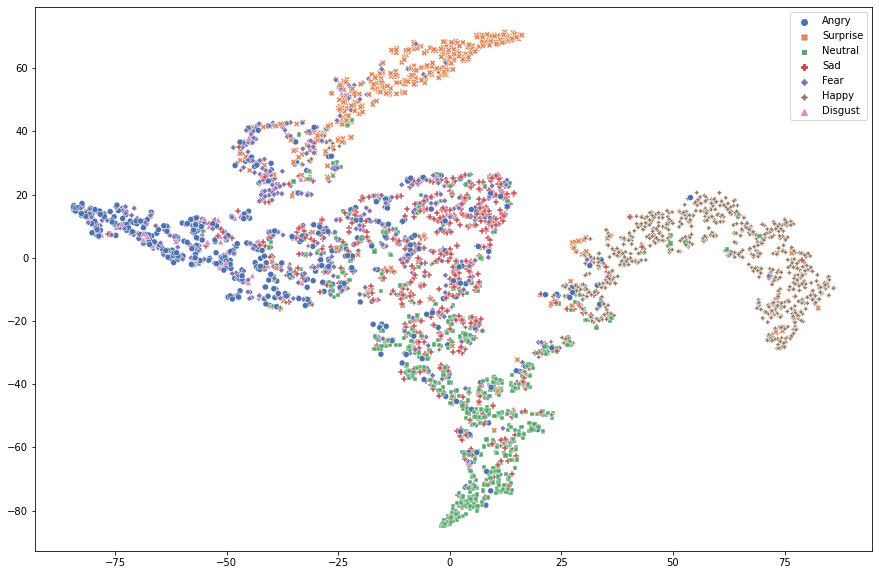

In [148]:
visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path=None)

(<Figure size 1080x720 with 1 Axes>,
 array([[-50.326553 , -14.505447 ],
        [-18.60711  ,   9.776424 ],
        [-42.092407 ,  28.791391 ],
        ...,
        [-35.918957 ,   2.7822497],
        [ 51.328056 , -45.62121  ],
        [-55.418793 ,  15.2677145]], dtype=float32))

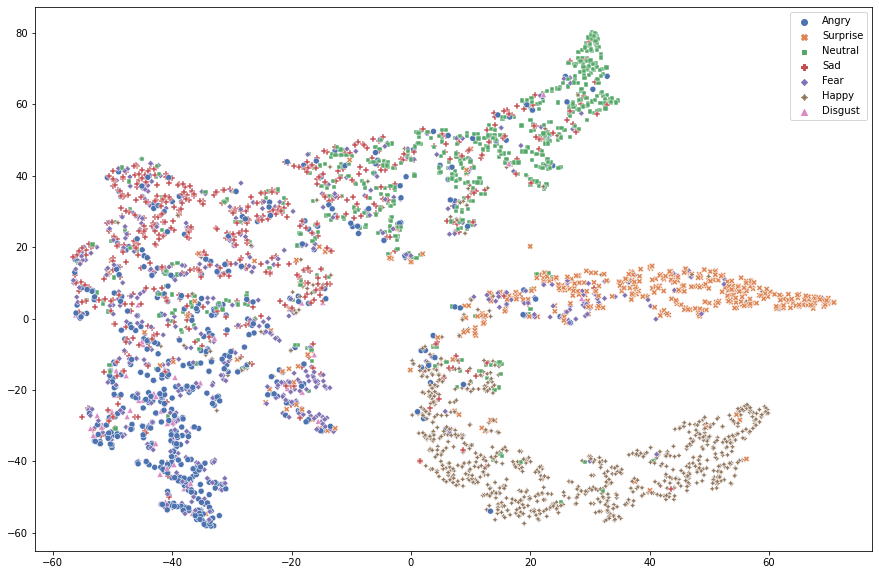

In [149]:
visualize_embedding(h1s.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path=None)

(<Figure size 1080x720 with 1 Axes>,
 array([[  2.9168775, -28.035898 ],
        [ 25.996616 ,  -4.0565886],
        [ 26.187084 ,  19.575773 ],
        ...,
        [ 10.283119 ,  -4.304932 ],
        [  8.043606 ,  80.39372  ],
        [  9.474043 ,  12.947158 ]], dtype=float32))

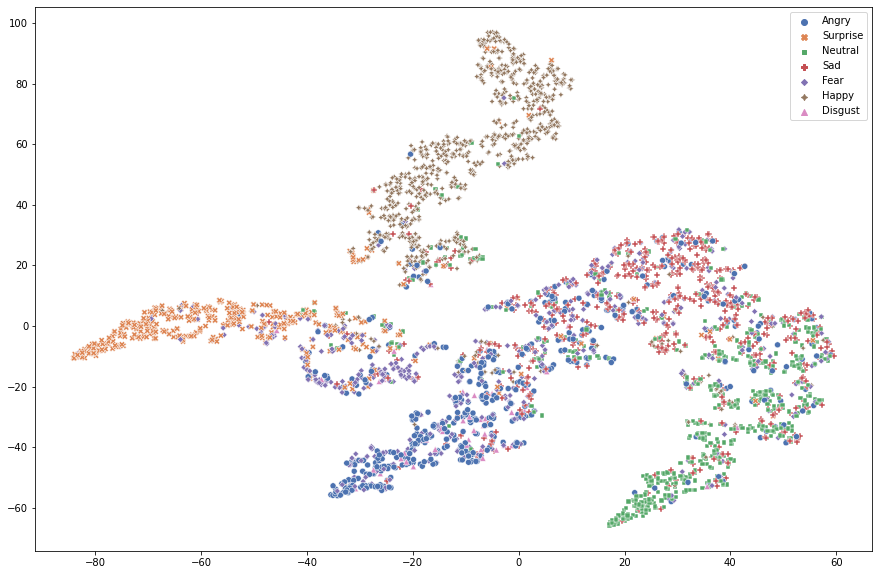

In [150]:
visualize_embedding(h2s.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path=None)

(<Figure size 1080x720 with 1 Axes>,
 array([[ -4.498244 ,  18.801348 ],
        [ 14.5864525, -13.584385 ],
        [ 41.507282 ,  -5.394064 ],
        ...,
        [ 11.914558 ,   3.3656137],
        [-14.070976 ,  80.32989  ],
        [ 40.09592  ,  10.821421 ]], dtype=float32))

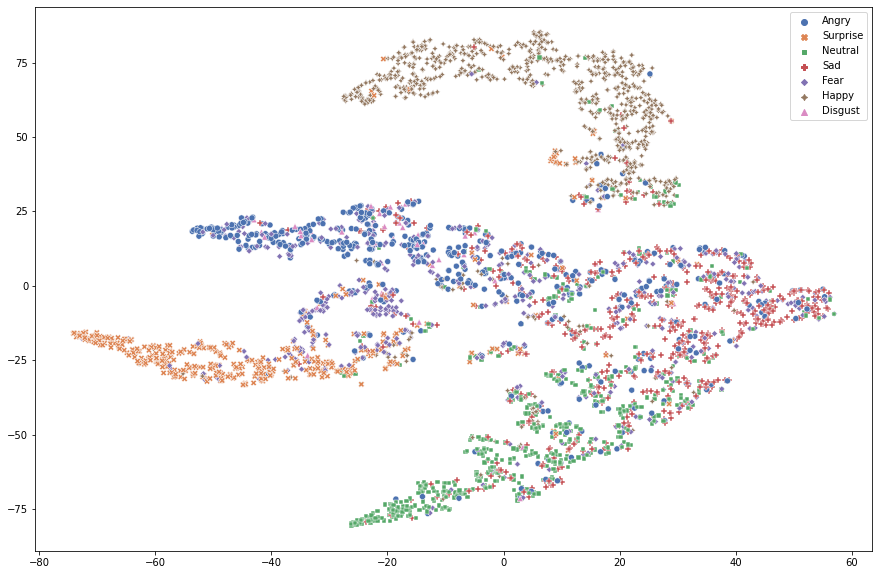

In [151]:
visualize_embedding(h1s.numpy() + h2s.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path=None)